In [1]:
%load_ext autoreload
%autoreload 2
#python v3.11.3

In [2]:

import warnings
#to suppress seaborn palette warnings
warnings.filterwarnings("ignore", category=UserWarning)
#to suppress seaborn error estimation NaN warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
import datetime

import numpy as np #v1.25.0
import pandas as pd #v2.0.3

import scipy #v1.10.1
import scipy.stats as stats
from scipy.optimize import curve_fit
import pingouin as pg

import seaborn as sns #v0.13.0
import matplotlib as mpl #v3.8.1
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.patches import Rectangle
from matplotlib.collections import LineCollection


# these files should be in the same directory as this Jupyter notebook
from format_arduino_data import *
from lickfrequency_analysis import *
from plot_data import *

# to set styles for plotting
mpl.style.use(r"C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\mouse_analysis\full_trial_analysis\mouse_analysis.mplstyle")

#to suppress inaccurate pandas reassignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

### Lick frequency heatmap analysis

In [3]:
def load_data(path, data_type, data_name, conds, dtype_map, cols):
    dataset  = []
    cols = cols.copy()
    for cond in conds:
        o_data = pd.read_csv(path + cond + '\\' + data_type + '_' + cond + '_' + data_name + '.txt', dtype=dtype_map)
        rm = []
        for c in cols:
            if c not in o_data.columns:
                rm.append(c)
        for c in rm:
            cols.remove(c)
        o_data = o_data[cols]
        dataset.append(o_data)
    dataset = pd.concat(dataset)
    dataset = dataset.replace({pd.NA:'u'})
    return dataset

def format_strain(df):
    df.loc[(df['Strain'] == 'SSTcre/Ai32-')|(df['Strain'] == 'Sscre x Ai32 -'), 'Strain'] = 'SSTcre x Ai32-'
    df.loc[(df['Strain'] == 'SSTcre x Ai32')|(df['Strain'] == 'Sscre x Ai32'), 'Strain'] = 'SSTcre x Ai32'
    df.loc[(df['Strain'] == 'SSTcre')|(df['Strain'] == 'Sscre'), 'Strain'] = 'SSTcre'
    df.loc[df['Strain'] == 'Scnnn-cre + Vehicle', 'condition'] = 'Vehicle'
    df.loc[df['Strain'] == 'Scnnn-cre + Vehicle', 'Strain'] = 'Scnn-cre'
    df.loc[(df['Strain']=='Scnn-cre+6OHDA partial'),'condition'] = '6ohda partial'
    df.loc[(df['Strain']=='Scnn-cre')|(df['Strain']=='Scnn-cre + 6OHDA')|(df['Strain']=='Scnn-cre+6OHDA partial'), 'Strain'] = 'Scnn-cre'
    df.loc[(df['Strain']=='.1-3/sscre'), 'Strain'] = '.1-3 x SSTcre'
    df.loc[df['Strain'] == '1-3 x Scnn-cre (1-3 WT)', 'Strain'] = '.1-3- x Scnn-cre'
    df.loc[df['Strain'] == '1-3 x Scnn-cre (1-3 Het)', 'Strain'] = '.1-3+ x Scnn-cre'

def format_condition(df):
    df["cond"] = df["condition"].replace({"hm4di_cno": "hM4Di + CNO", "mcherry_cno": "mCherry + CNO", 
                            '0.1 mg DCZ hm4di': "hM4Di + DCZ", 
                            '0.1 mg DCZ mcherry': "mCherry + DCZ", 
                            '0.5 mg DCZ mcherry':"mCherry + DCZ",  
                            '0.5 mg DCZ hm4di': "hM4Di + DCZ",
                            '100acc80acc':'100ACC80ACC',
                            "all_reward": "100ACC80SAT",
                            "SAT": "SAT", 'sat1':'SAT', 'sat5':'SAT', 
                            'SAT1':'SAT', 'SAT2':'SAT','SAT5':'SAT',
                            'acc2':'ACC', 'acc3':'ACC', 'acc7':'ACC',
                            'Ipsi-lesion':'Ipsi-lesion', 
                            'Contra-lesion':'Contra-lesion'})
    df['test_time'] = 'train'
    df.loc[df['condition'].str.contains('train'), 'cond'] = df.loc[df['condition'].str.contains('train'), 'condition'].str.rstrip('retrain').str.rstrip(' ')
    df.loc[df['condition'].str.contains('ipsi'), 'cond'] = 'ipsi lesion'
    df.loc[df['condition'].str.contains('sham'), 'cond'] = 'sham lesion'
    df.loc[df['condition'].str.contains('train'), 'test_time'] = df.loc[df['condition'].str.contains('train'), 'condition'].str.lstrip('contrlaipshm').str.lstrip(' ').str.lstrip('lesion').str.lstrip(' ')
    df.loc[df['test_time'].str.contains('retrain'), 'test_time'] = '5d test'
    df.loc[df['condition'].str.contains('test'), 'cond'] = df.loc[df['condition'].str.contains('test'), 'condition'].str.rstrip('test').str.rstrip(' ')
    df.loc[df['condition'].str.contains('test'), 'test_time'] = '21d test'

def format_cage(df):
    df['Cage'] = df['Cage'].str.upper()
    df.loc[df['Cage'] == 'UNKNOWN', 'Cage'] = 'U'
    df.loc[df['Cage'].isna(), 'Cage'] = 'U'

def format_all(df):
    if df['Day'].all():
        df['Day'] = df['Day'].apply(day_to_label)
    format_cage(df)
    format_strain(df)
    format_condition(df)

In [4]:
dtype_map = {'condition':str,'animal':str, 'stimulus':str, 'lick':float, 'Strain':str, 'Cage':str, 'type':str, 'Time (ms)':float, 'Time (hr)':float, 'Day':float, 'water':str}
perf_cols = ['condition', 'animal', 'Strain', 'Age', 'Cage', 'Date', 'acc', 'Time (hr)', 'Day']
lf_cols = perf_cols + ['stimulus', 'water', 'type']
conds = ['joe']
data_path = r'C:\Users\swind\Documents\lab_work\Barth\behavior_analysis\6ohda_for_Joe\analyzed\'
to_load = {'full means_filtered':'', 'full performance_filtered':'', 'anticipatory means_filtered':'', 'anticipatory performance_filtered':'',
           'anticipatory trial_counts':''}
for type_name in to_load:
    data_type, data_name = type_name.split(' ')
    val = ['trial no'] if 'trial' in data_name else ['lick']
    cols = perf_cols if 'performance' in data_name else lf_cols
    ms = ['Time (ms)']  if 'full' in data_type else []
    to_load[type_name] = load_data(data_path, data_type, data_name, conds, dtype_map, cols + ms + val)
    format_all(to_load[type_name])

means_full = to_load['full means_filtered']
perf_full = to_load['full performance_filtered']
ant_perf = to_load['anticipatory performance_filtered']
ant_means = to_load['anticipatory means_filtered']
trials = to_load['anticipatory trial_counts']

C:\Users\swind\AppData\Local\Temp\ipykernel_10784\1602684788.py:5: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  o_data = pd.read_csv(path + cond + '\\' + data_type + '_' + cond + '_' + data_name + '.txt', dtype=dtype_map)


C:\Users\swind\AppData\Local\Temp\ipykernel_10784\1602684788.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  o_data = pd.read_csv(path + cond + '\\' + data_type + '_' + cond + '_' + data_name + '.txt', dtype=dtype_map)


In [5]:
def get_means(df, gpcols):
    means = df.groupby(gpcols)['lick'].mean()
    kpcols = df.columns.drop(gpcols + ['lick'])
    kp  = df.groupby(gpcols)[kpcols].first()
    means = pd.concat([means, kp], axis=1).reset_index()
    return means

In [6]:
gpcols = ['condition', 'Time (hr)', 'Time (ms)']
perf_full_means = get_means(perf_full, gpcols)
gpcols = gpcols + ['stimulus']
means_full_means = get_means(means_full[(means_full['Strain'].str.contains('Scnn'))], gpcols)

Text(0.5, 1.01, 'Instentaneous licking')

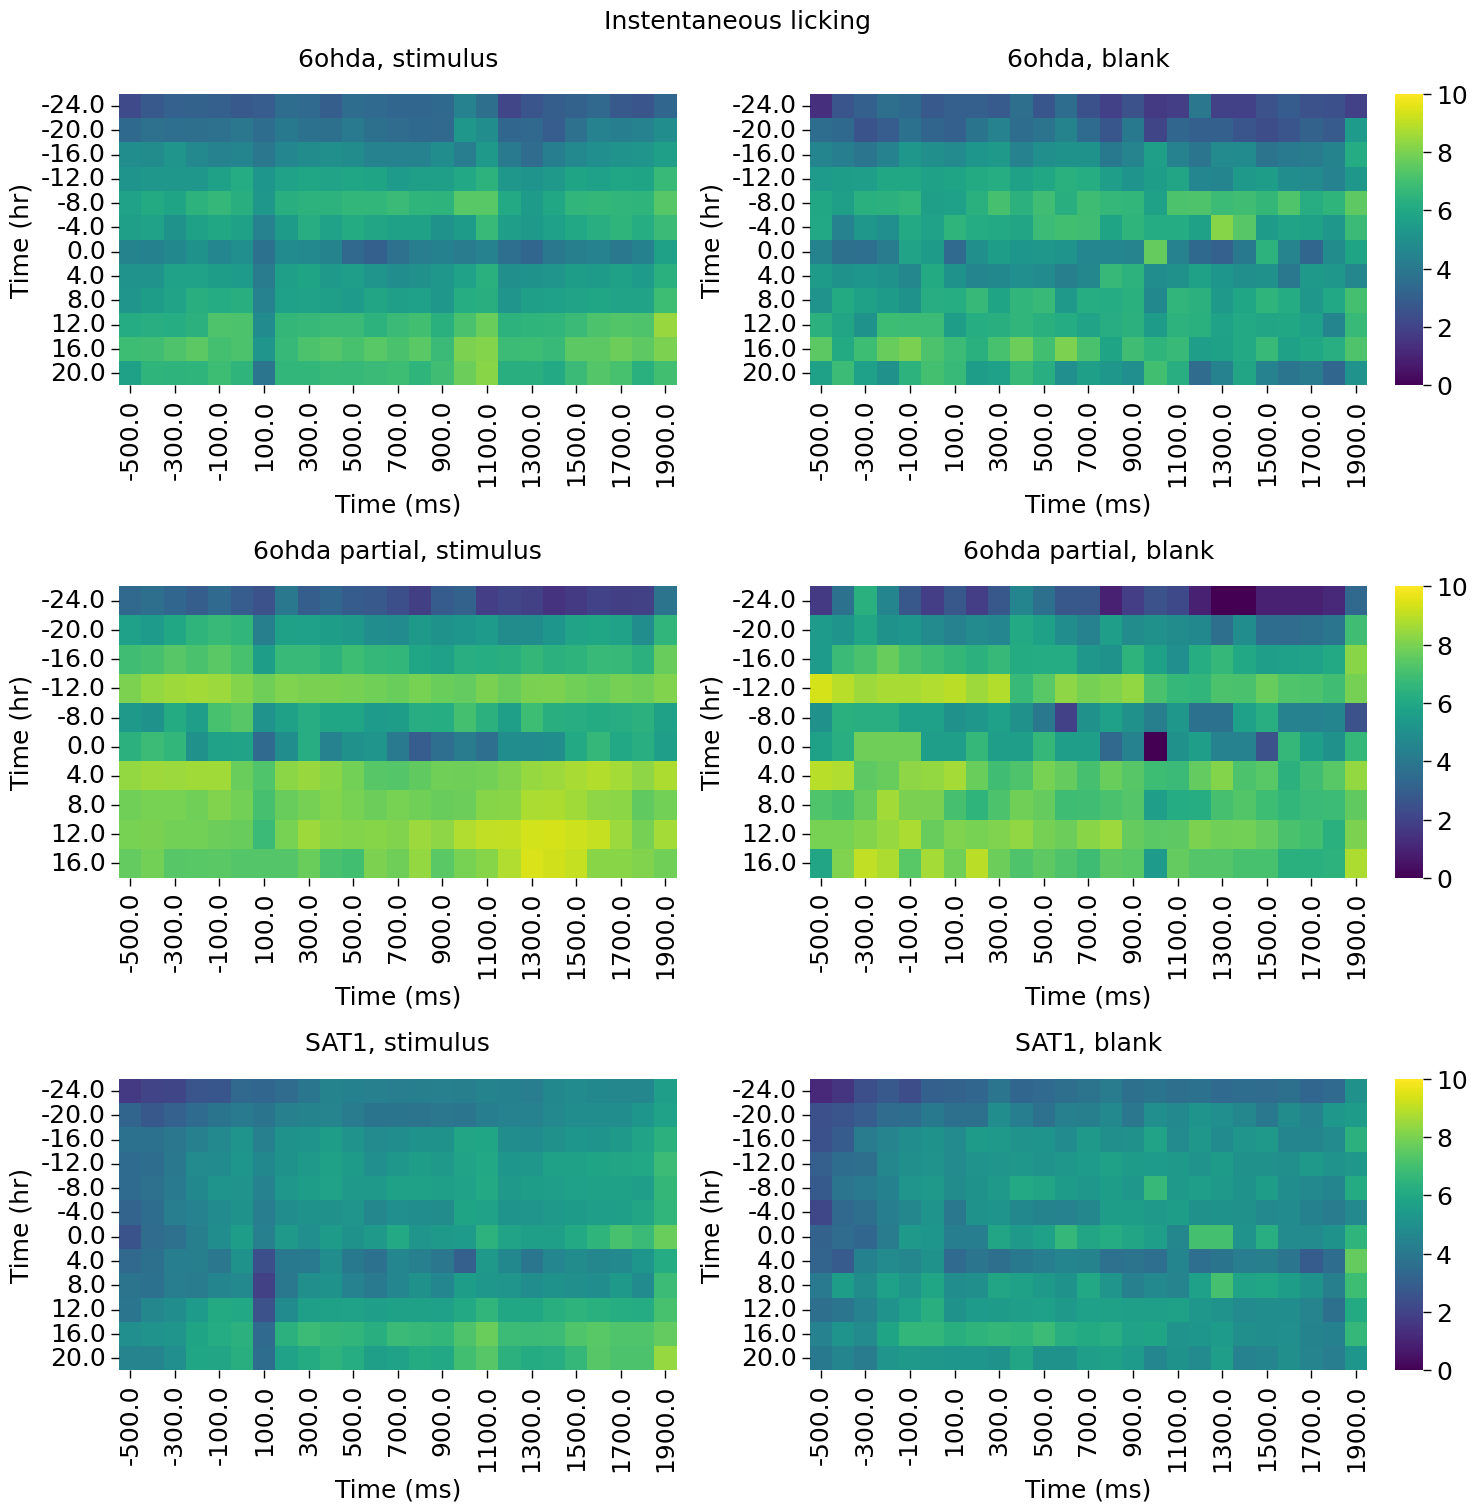

In [7]:
conds = ['6ohda', '6ohda partial', 'SAT1']
heatmap_data = means_full_means[(means_full_means['Time (hr)'] >= -24) & (means_full_means['Time (hr)'] < 24) 
                             & (means_full_means.apply(lambda x: x['condition'] in conds, axis=1))
                             & (means_full_means['Time (ms)'] < 2000) & (means_full_means['Time (ms)'] > -600) 
                             ]
heatmap_data = heatmap_data.sort_values(['Time (hr)', 'Time (ms)'])

htmp_args=['Time (ms)', 'Time (hr)', 'lick']
fg = draw_facet(heatmap_data, htmp_args, draw_heatmap, col='stimulus', row='condition',
                col_order=['stimulus', 'blank'],
                row_order=['6ohda', '6ohda partial','SAT1'],
                cmap='viridis', vmin=0, vmax=10)
fg.suptitle('Instentaneous licking', y=1.01)

Text(0.5, 1.01, 'Instentaneous performance')

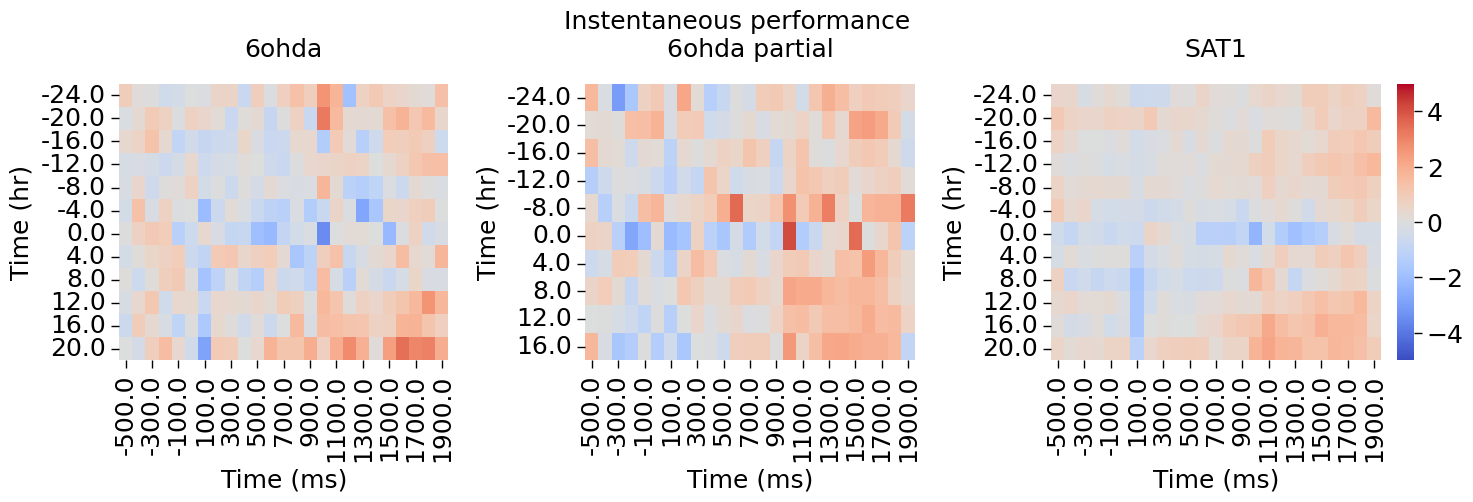

In [8]:
conds = ['6ohda', '6ohda partial', 'SAT1']
heatmap_data = perf_full_means[(perf_full_means['Time (hr)'] >= -24) & (perf_full_means['Time (hr)'] < 24) 
                             & (perf_full_means.apply(lambda x: x['condition'] in conds, axis=1))
                             & (perf_full_means['Time (ms)'] < 2000) & (perf_full_means['Time (ms)'] > -600) 
                             ]
heatmap_data = heatmap_data.sort_values(['Time (hr)', 'Time (ms)'])
htmp_args=['Time (ms)', 'Time (hr)', 'lick']
fg = draw_facet(heatmap_data, htmp_args, draw_heatmap,col='condition',
                col_order=['6ohda', '6ohda partial','SAT1'],
                cmap='coolwarm', vmin=-5, vmax=5)
fg.suptitle('Instentaneous performance', y=1.01)

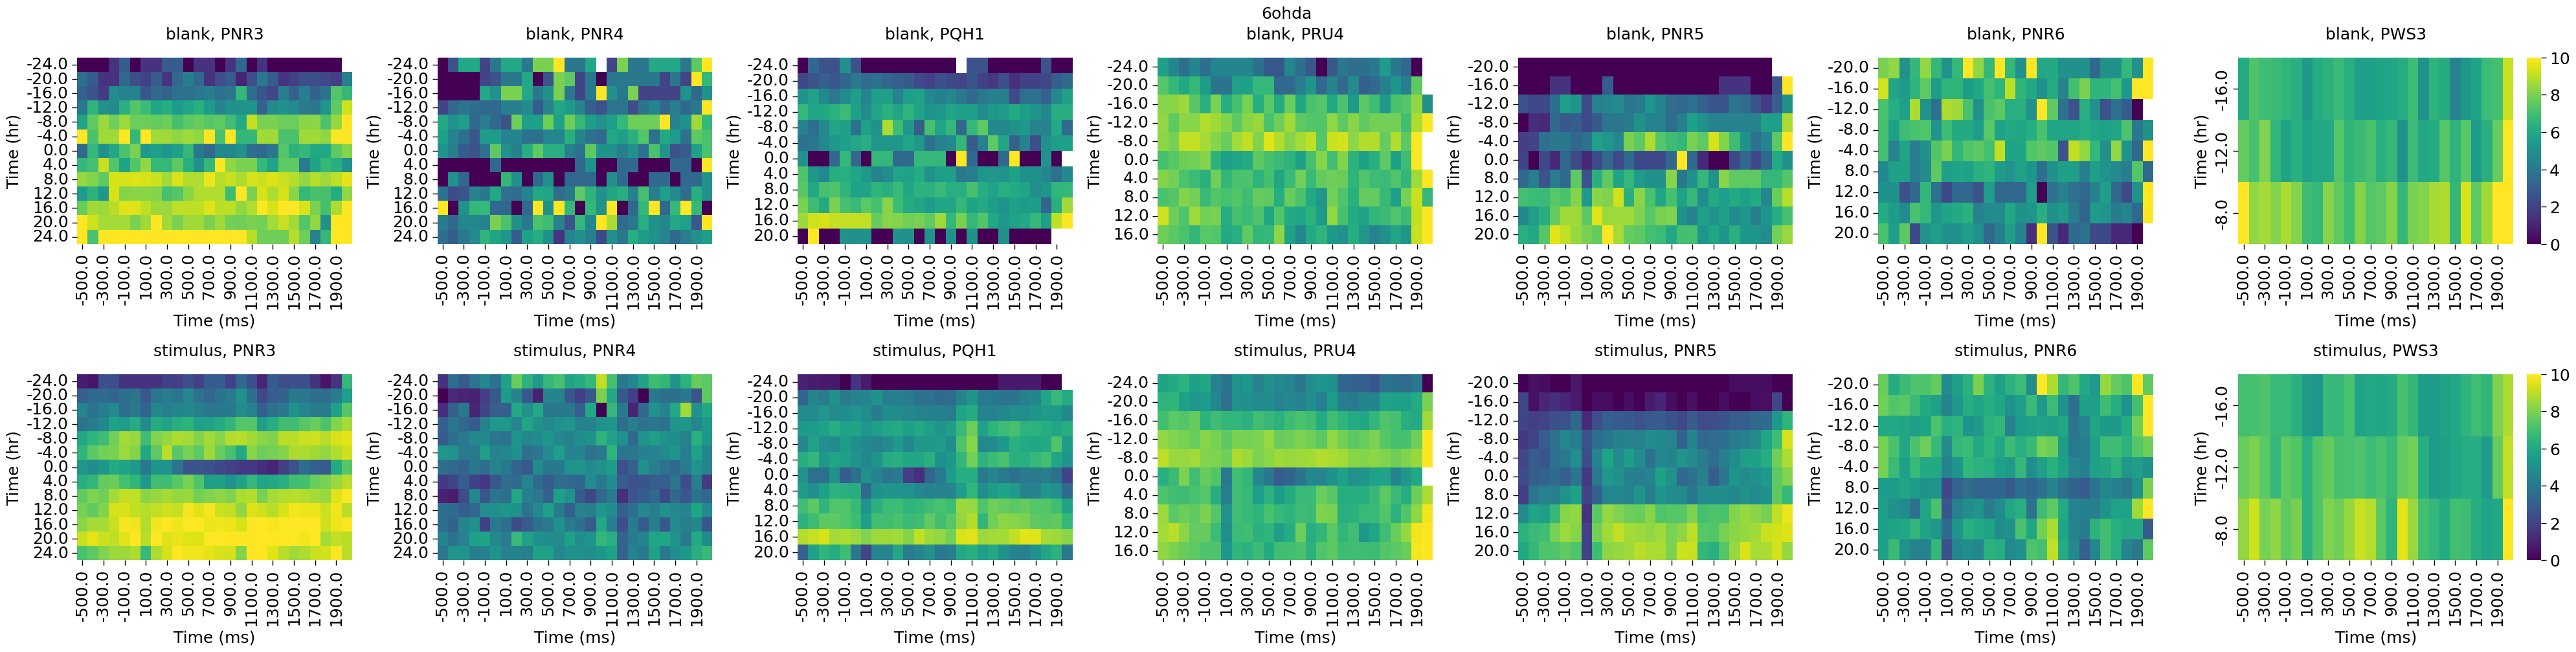

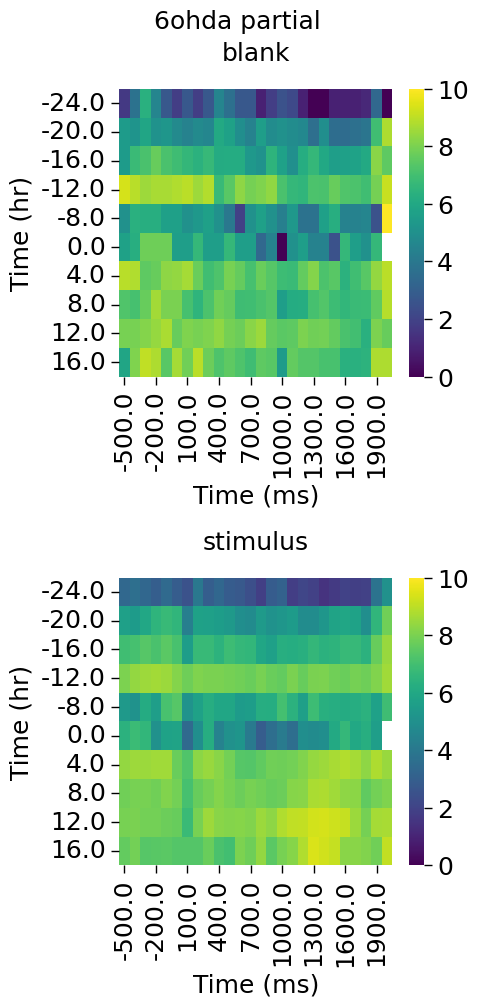

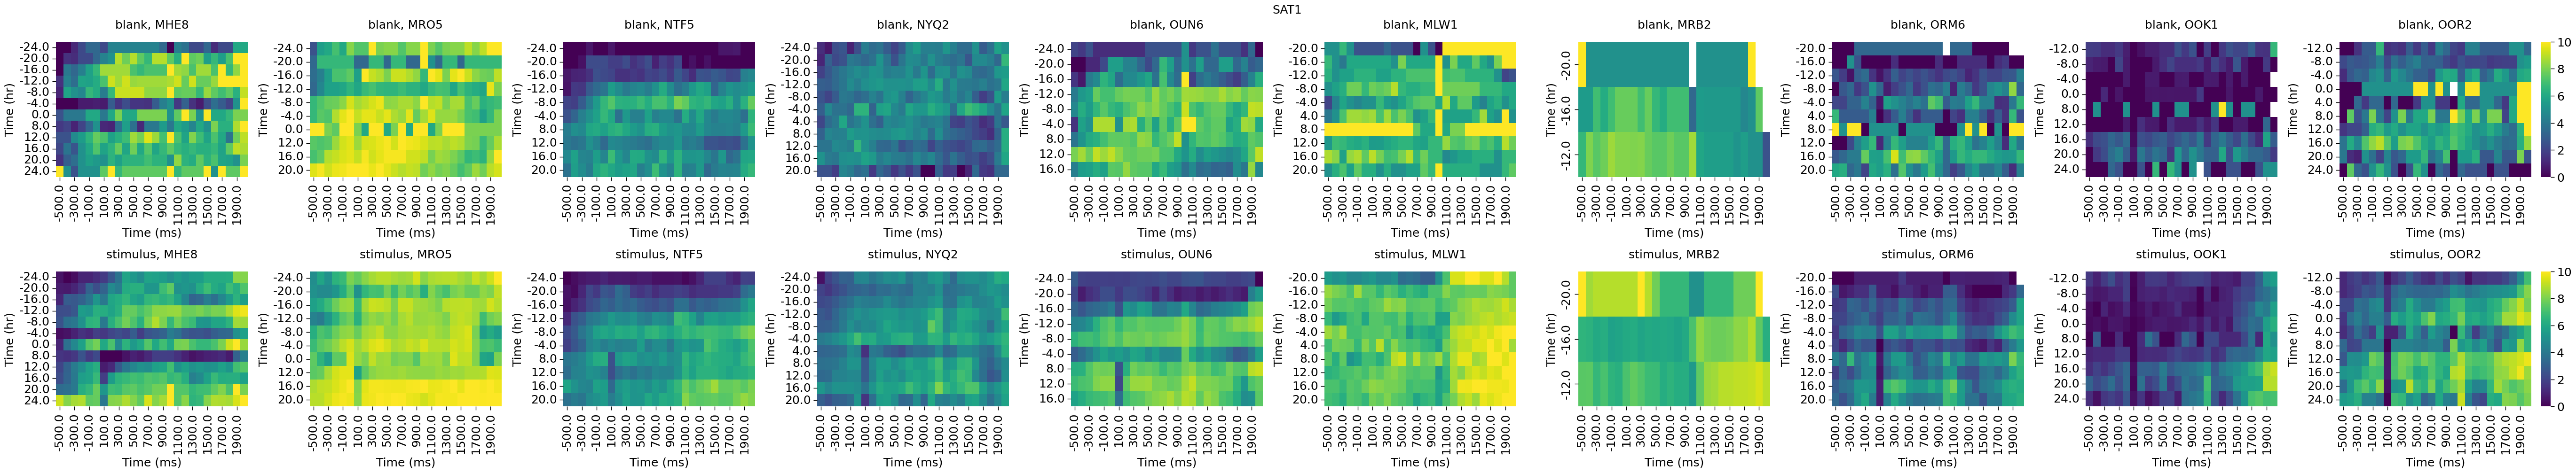

In [9]:
heatmap_data = means_full[(means_full['Time (hr)'] >= -24) & (means_full['Time (hr)'] <= 24)
                         &(means_full['Time (ms)'] >=-500) &(means_full['Time (ms)'] <= 2000)
                         &(means_full['Strain'].str.contains('Scnn'))]                    
heatmap_data = heatmap_data.sort_values(['Time (hr)', 'Time (ms)'])
conds = ['6ohda', '6ohda partial', 'SAT1']
for c in conds:
    plt_data = heatmap_data[(heatmap_data['condition'] == c)]
    fg = draw_facet(plt_data, htmp_args,draw_heatmap, col='animal',cmap='viridis', row='stimulus', vmin=0, vmax=10)
    fg.suptitle(c, y=1.01)

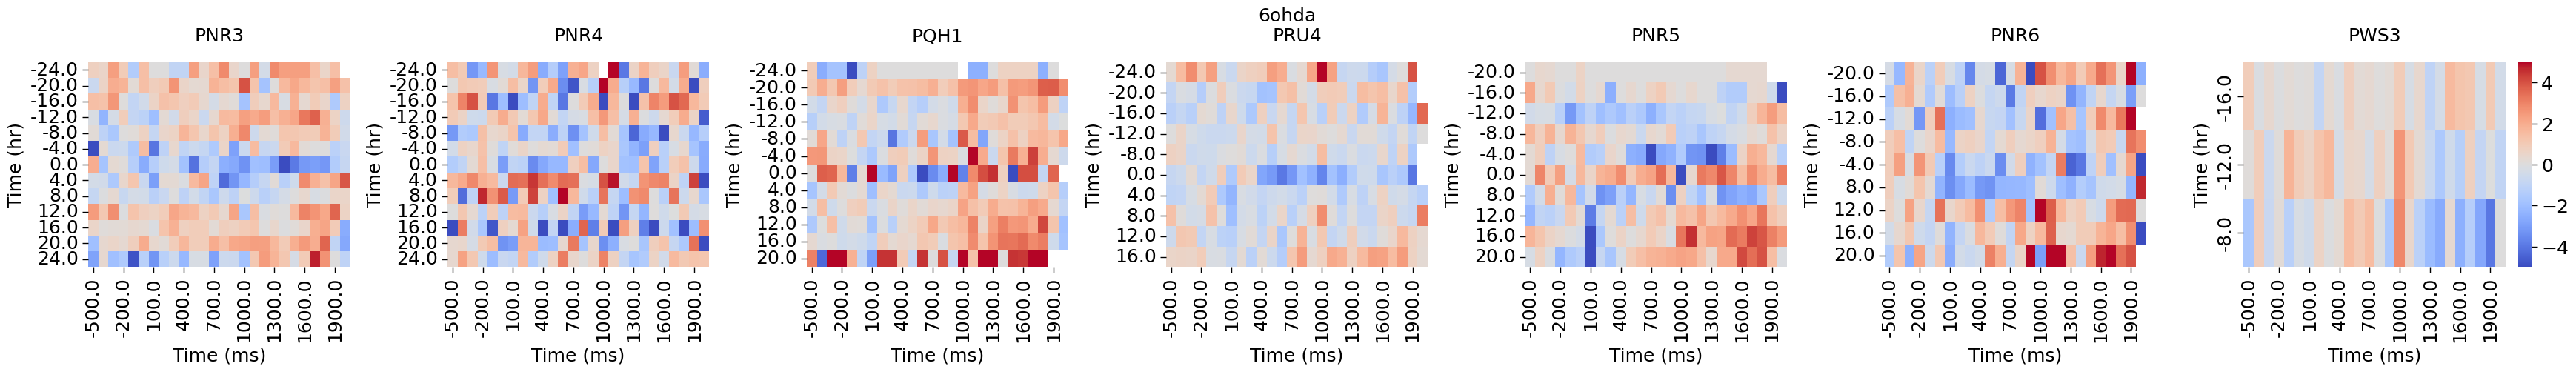

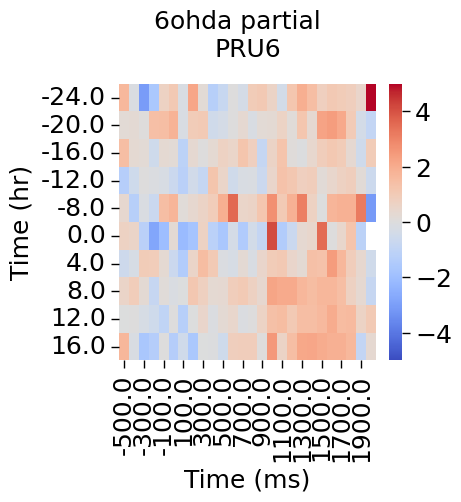

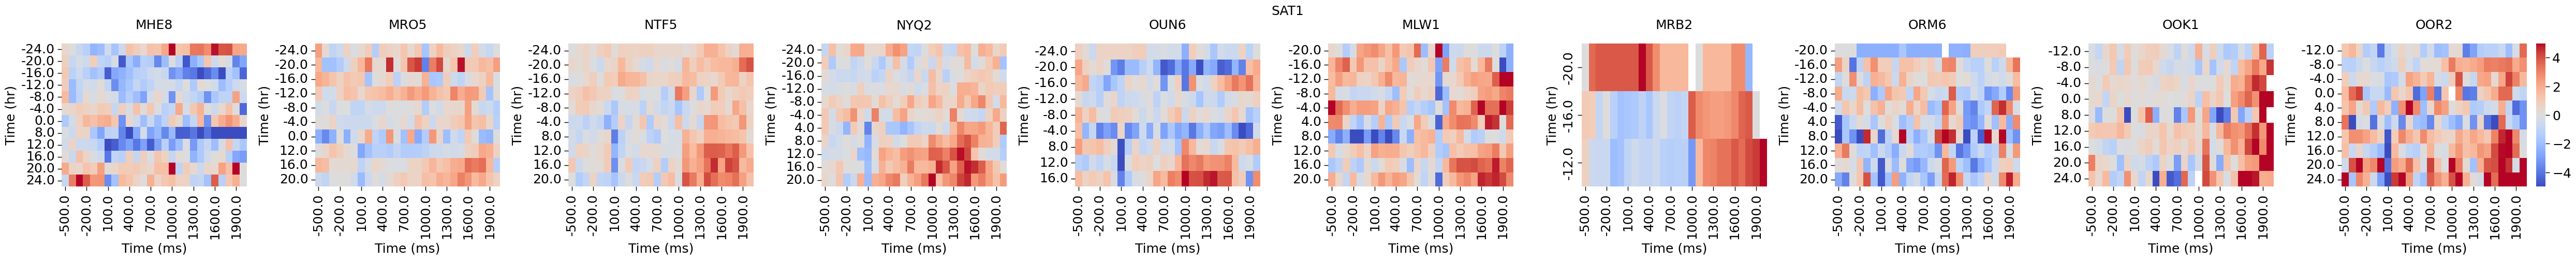

In [10]:
heatmap_data = perf_full[(perf_full['Time (hr)'] >= -24) & (perf_full['Time (hr)'] <= 24)
                         &(perf_full['Time (ms)'] >=-500) &(perf_full['Time (ms)'] <= 2000)
                         &(perf_full['Strain'].str.contains('Scnn'))]                    
heatmap_data = heatmap_data.sort_values(['Time (hr)', 'Time (ms)'])
conds = ['6ohda', '6ohda partial', 'SAT1']
for c in conds:
    plt_data = heatmap_data[(heatmap_data['condition'] == c)]
    fg = draw_facet(plt_data, htmp_args,draw_heatmap, col='animal',cmap='coolwarm', vmin=-5, vmax=5)
    fg.suptitle(c, y=1.01)

#### instentanteous lick frequency by hour

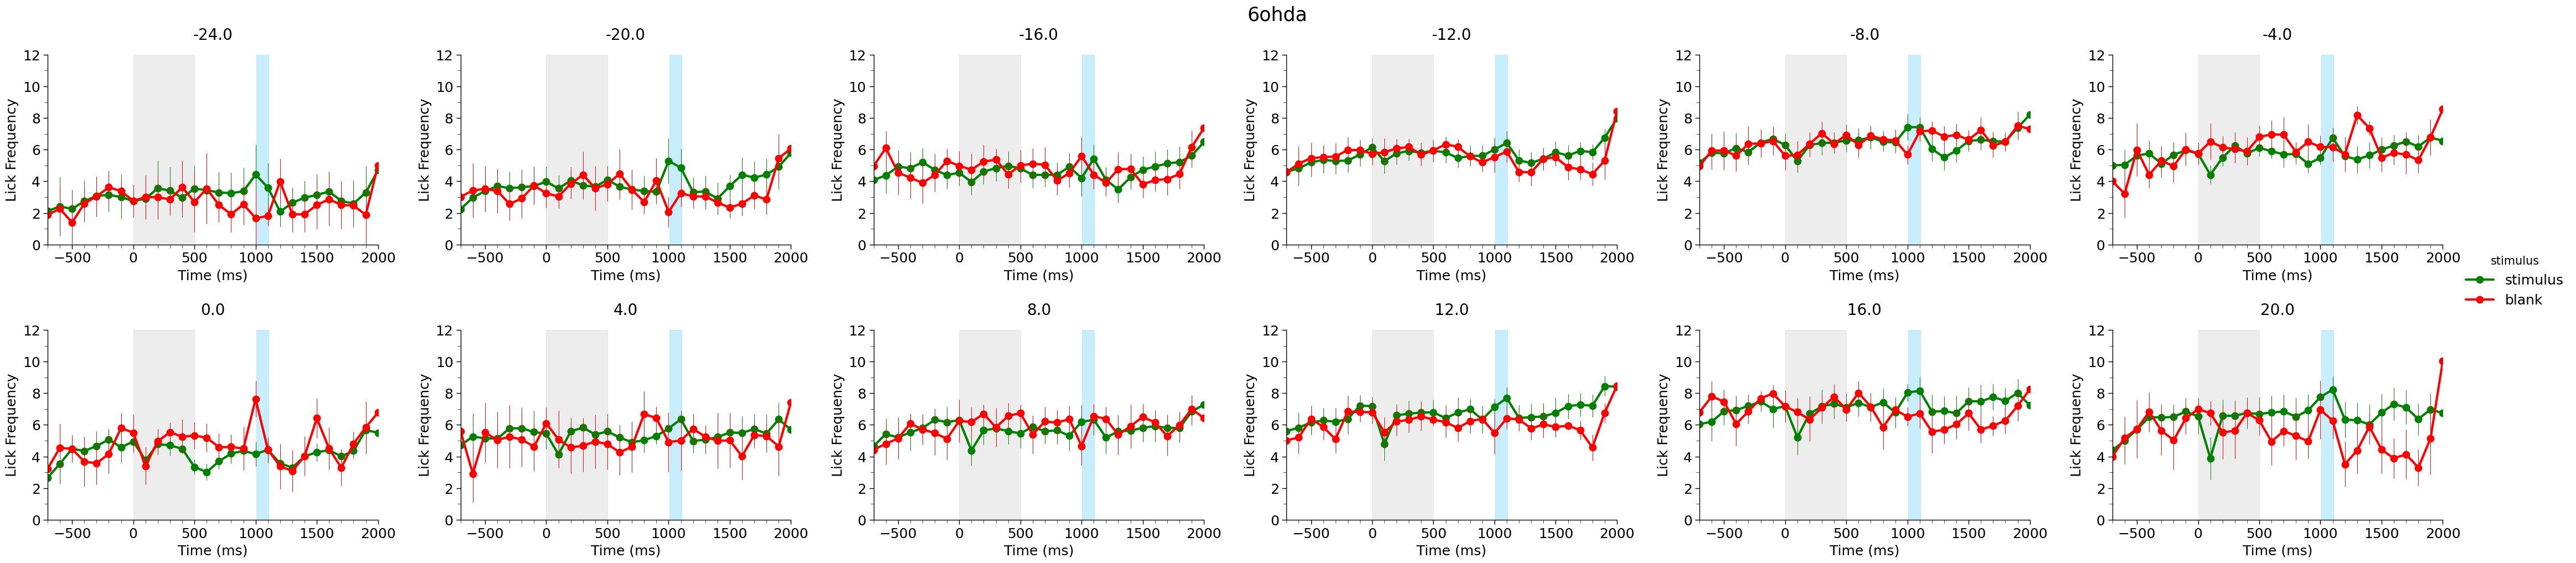

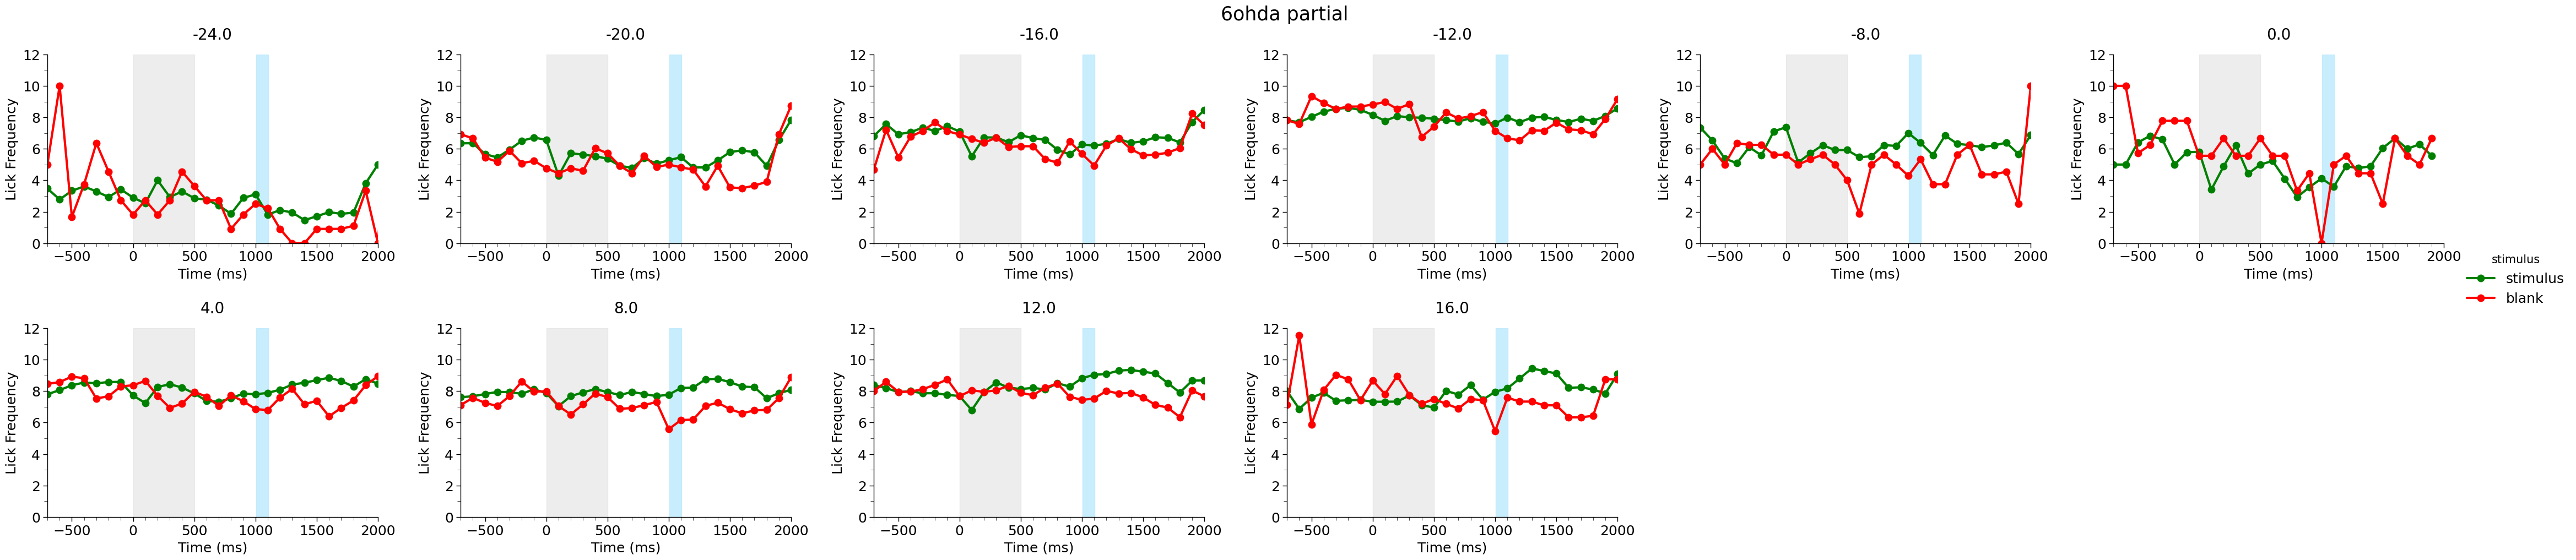

In [11]:
conds = ['6ohda', '6ohda partial']
for c in conds:
    plot_lickfreq(means_full[(means_full['condition'] == c) & (means_full['Time (hr)'] >= -24) & (means_full['Time (hr)'] < 24)], 
                            suptitle=c, col='Time (hr)', col_wrap=6, errorbar='se', err_style='bars', err_kws={'lw':0.7}, xlim=[-700, 2000])

#### instentaneous performance by hour

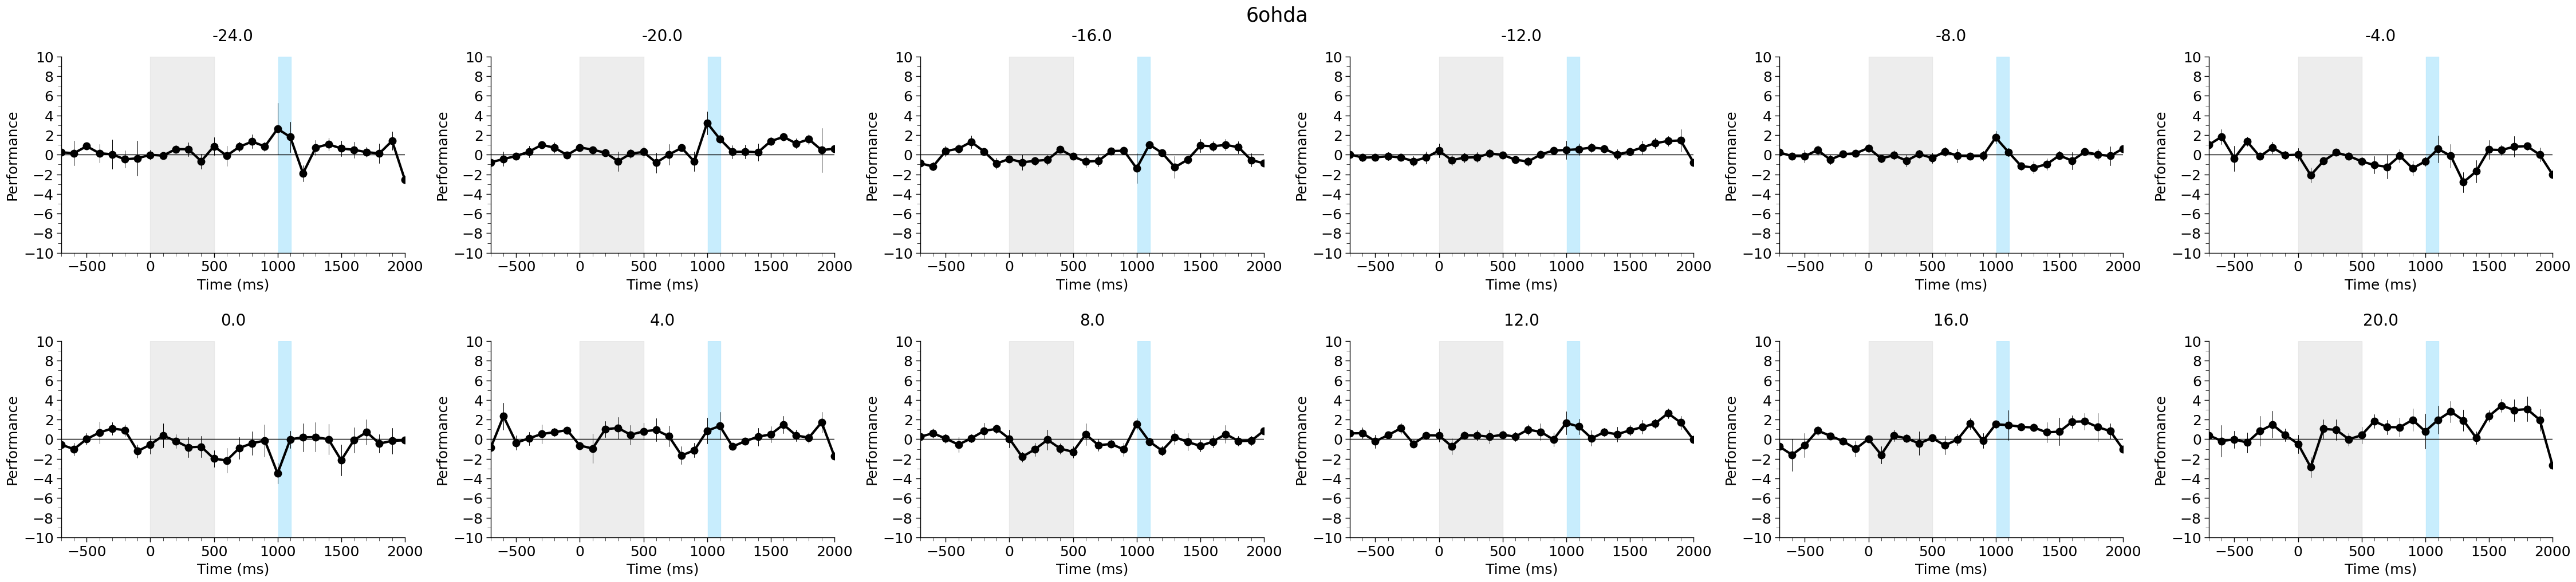

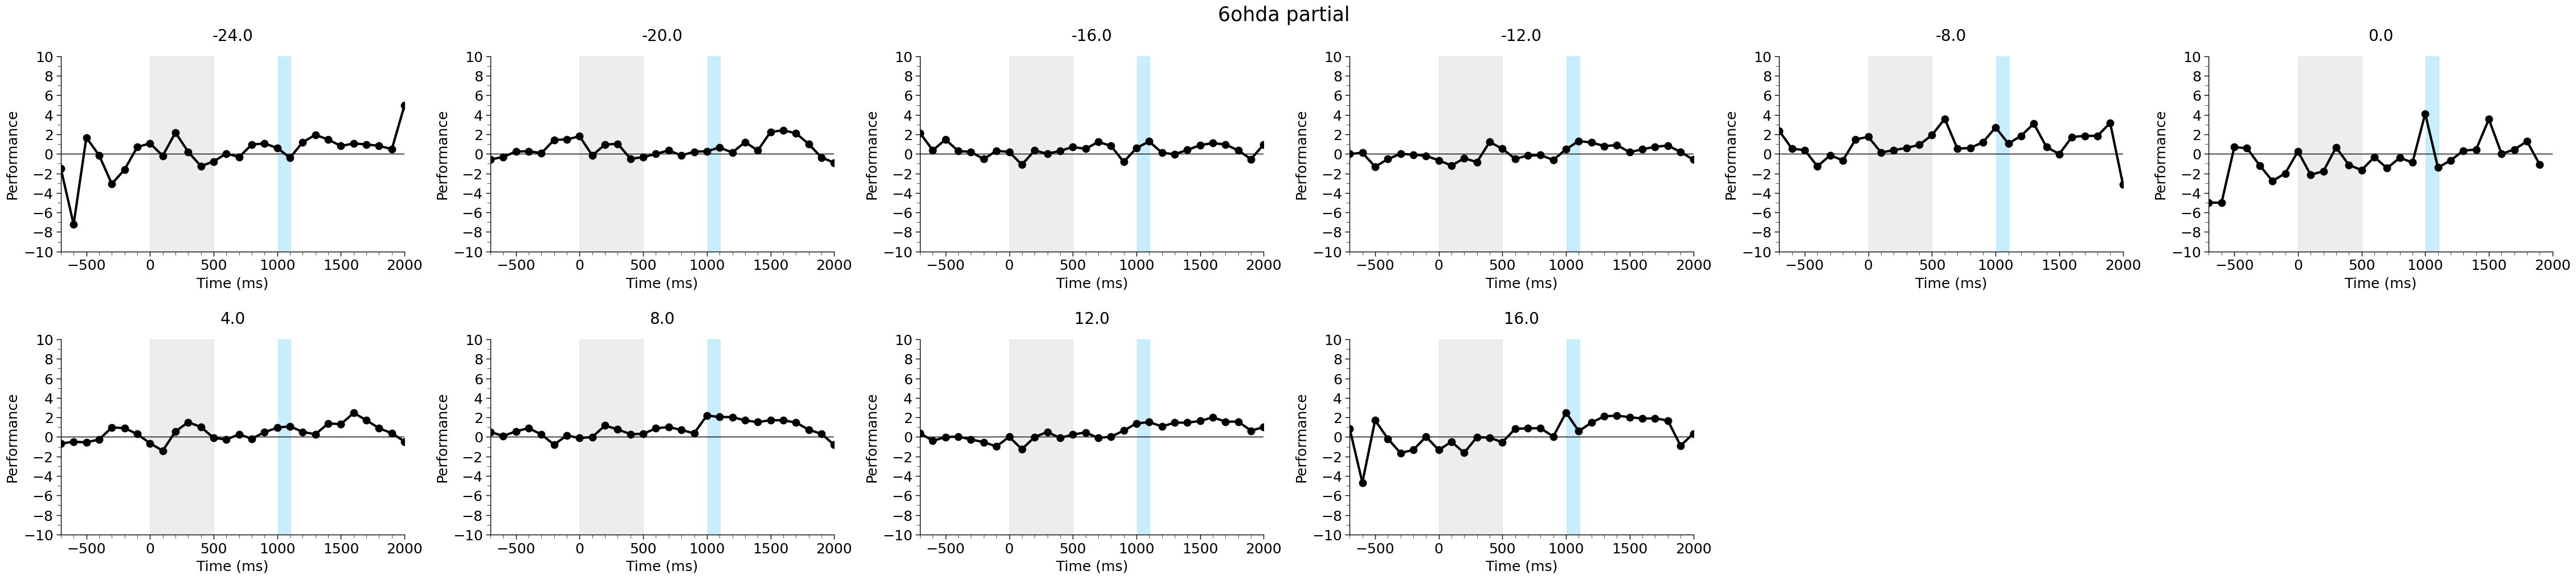

In [12]:
conds = ['6ohda', '6ohda partial']
for c in conds:
    plot_perf(perf_full[(perf_full['condition'] == c) & (perf_full['Time (hr)'] >= -24) & (perf_full['Time (hr)'] < 24)], 
              suptitle=c, col='Time (hr)', col_wrap=6, errorbar='se', err_style='bars', err_kws={'lw':0.7}, xlim=[-700, 2000],
              hue=None)

### anticipatory lick frequency

In [13]:
ant_means['Time (hr)'] = ant_means['Time (hr)'] + 2
ant_perf['Time (hr)'] = ant_perf['Time (hr)'] + 2
trials['Time (hr)'] = trials['Time (hr)'] + 2

In [14]:
# sum number of stimulus and blank trials together
trials = sum_trials(trials, ['condition', 'animal', 'Time (hr)'], ['Age','Strain', 'Date', 'Cage'], "trial no")

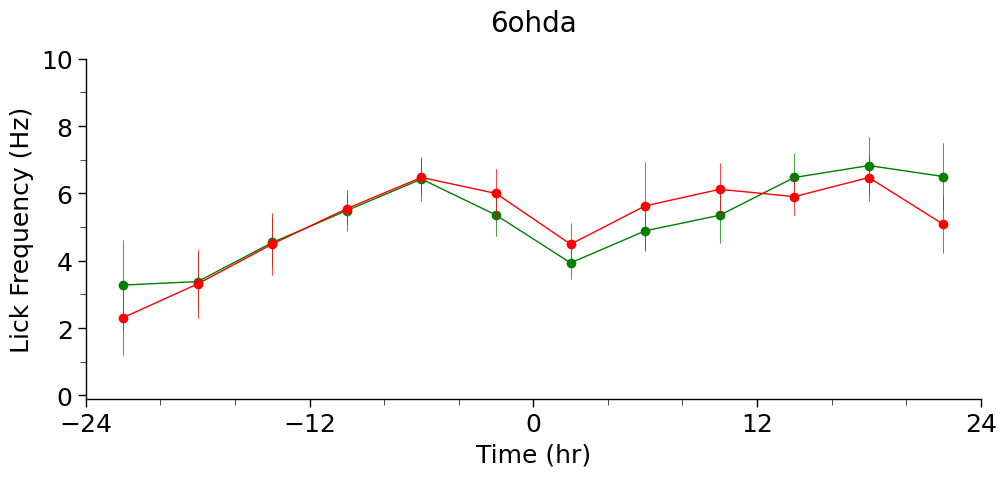

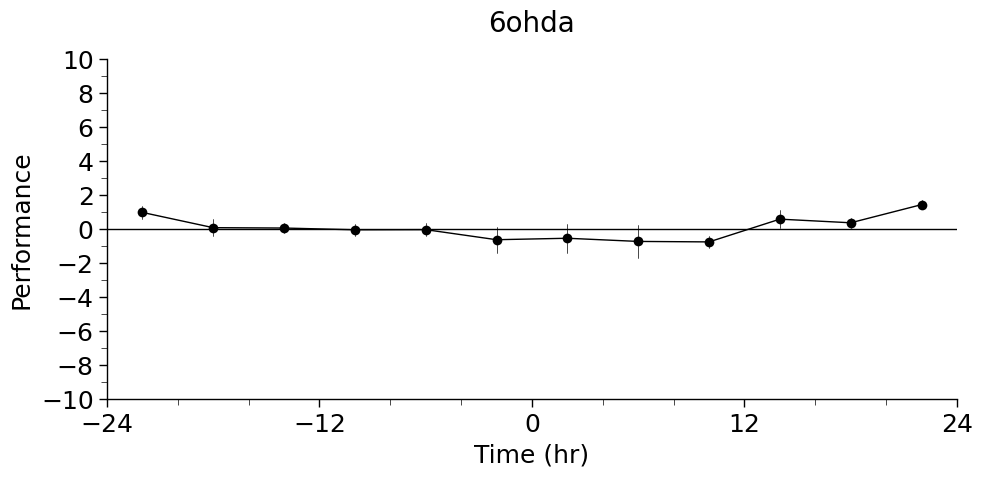

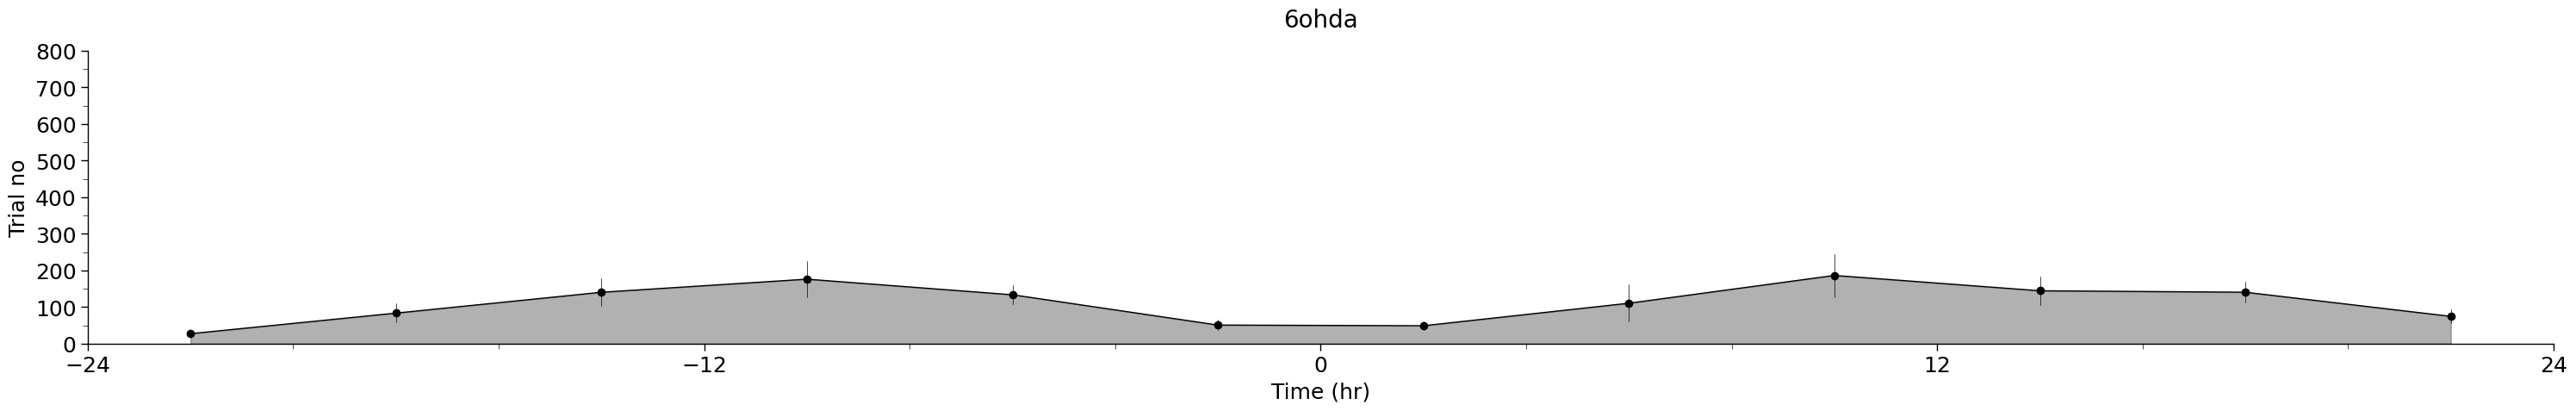

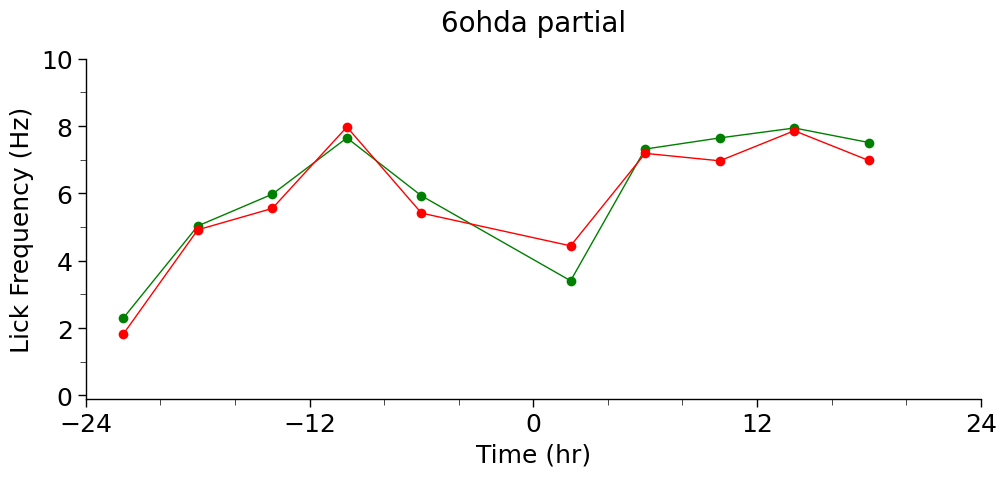

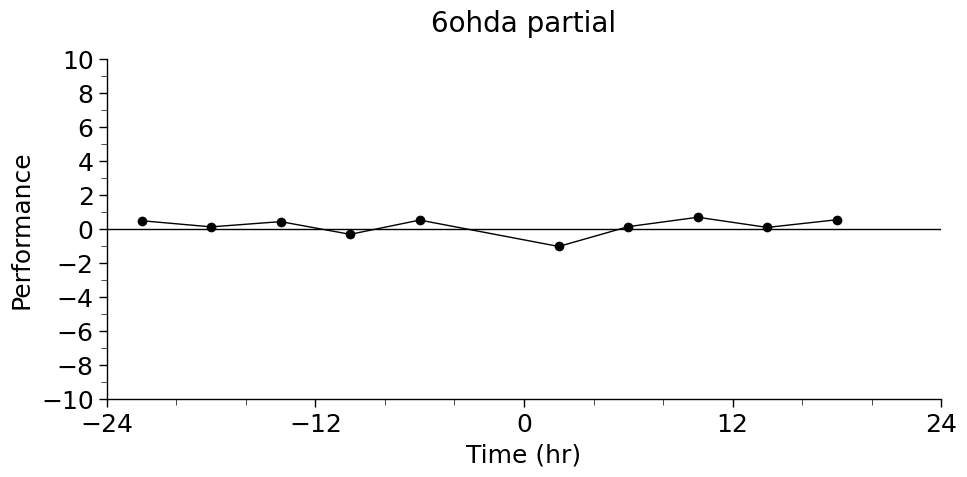

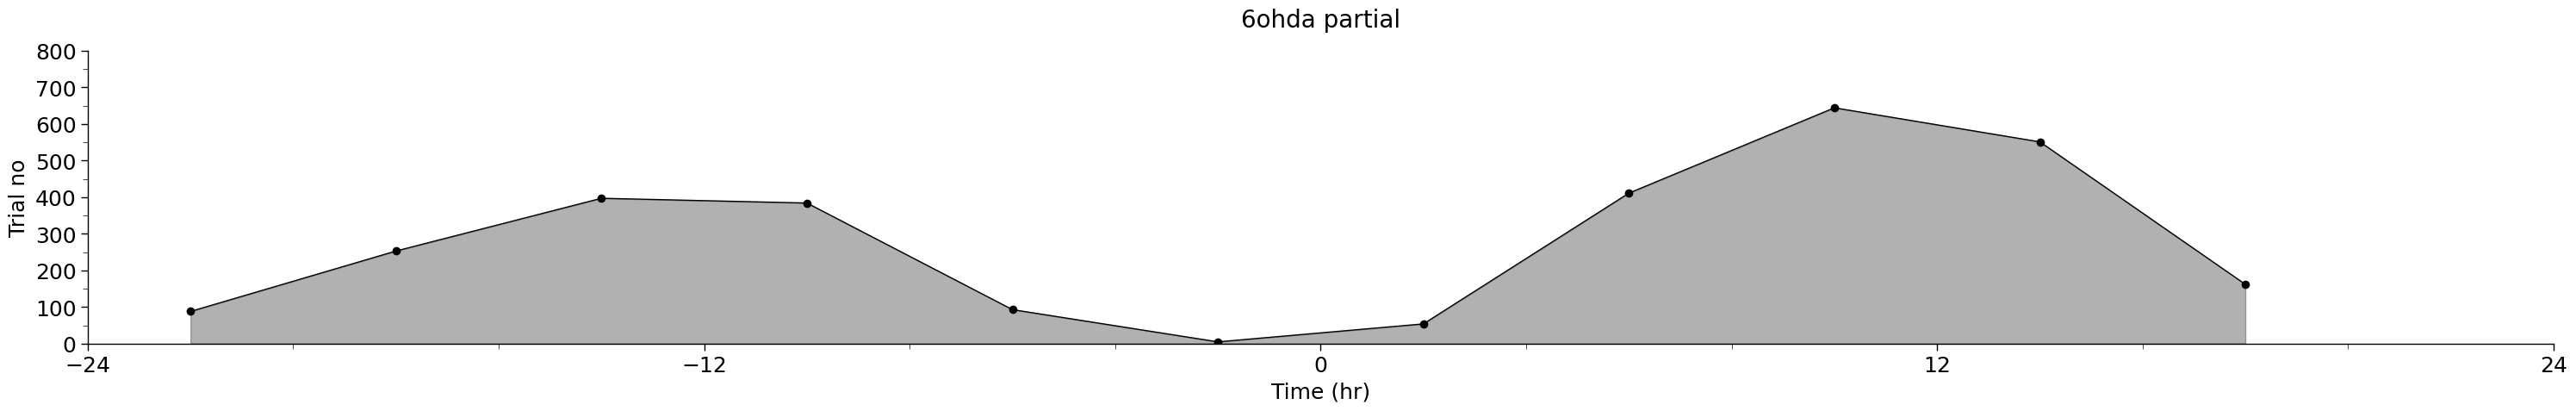

In [15]:
xlim=[-24,24]
conds = ['6ohda', '6ohda partial']
for c in conds:
    g = plot_ant_lickfreq(ant_means[(ant_means["condition"] == c) & (ant_means['Time (hr)'] >= -24) & (ant_means['Time (hr)'] < 24)],
                          y='lick', aspect=2,lw=1, ms=7, title=c, legend=False, 
                          xlim=xlim, ylim=[-0.1, 10], errorbar='se', 
                          err_style='bars', err_kws={"lw":0.5})
    g = plot_ant_perf(ant_perf[(ant_perf["condition"] == c)& (ant_perf['Time (hr)'] >= -24) & (ant_perf['Time (hr)'] < 24)], 
                      ylabel="Performance", aspect=2,lw=1, ms=7,xlim=xlim, legend=False, 
                      ylim=[-10, 10], title=c,errorbar='se', 
                      err_style='bars', err_kws={"lw":0.5})
    g = plot_trial_hr(trials[(trials["condition"] == c)& (trials['Time (hr)'] >= -24) & (trials['Time (hr)'] < 24)], 
                      xlim=xlim, ylim=[0, 800], aspect=6, title=c, ms=7, lw=1,
                      err_kws={"lw":0.5}, ylabel='Trial no')

#### anticipatory lick frequency by animal

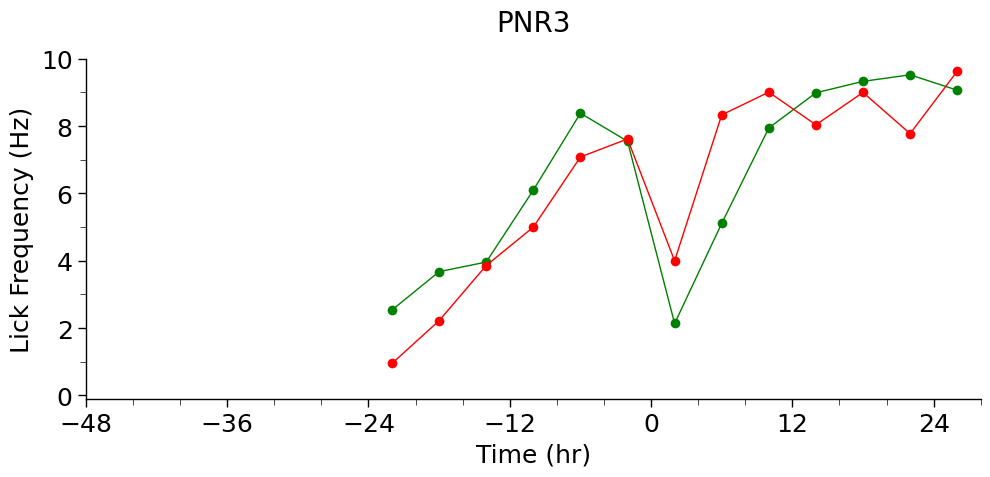

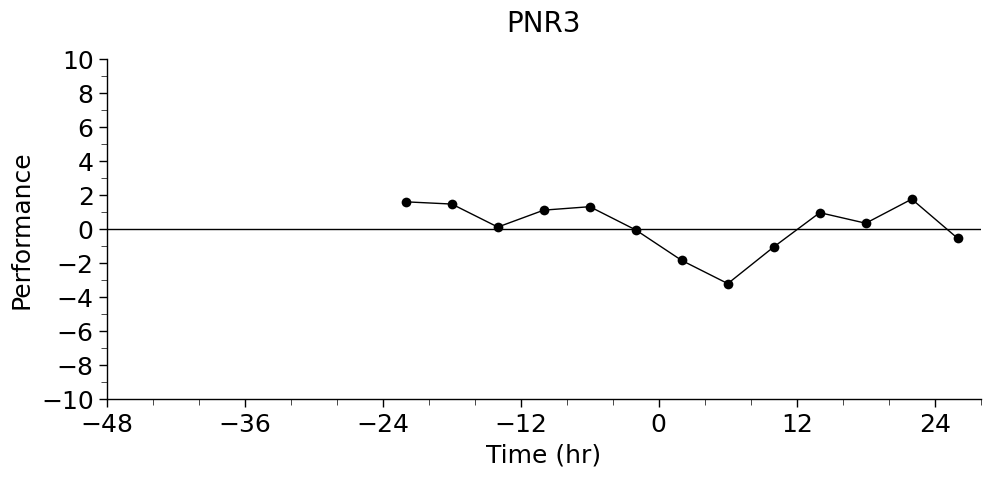

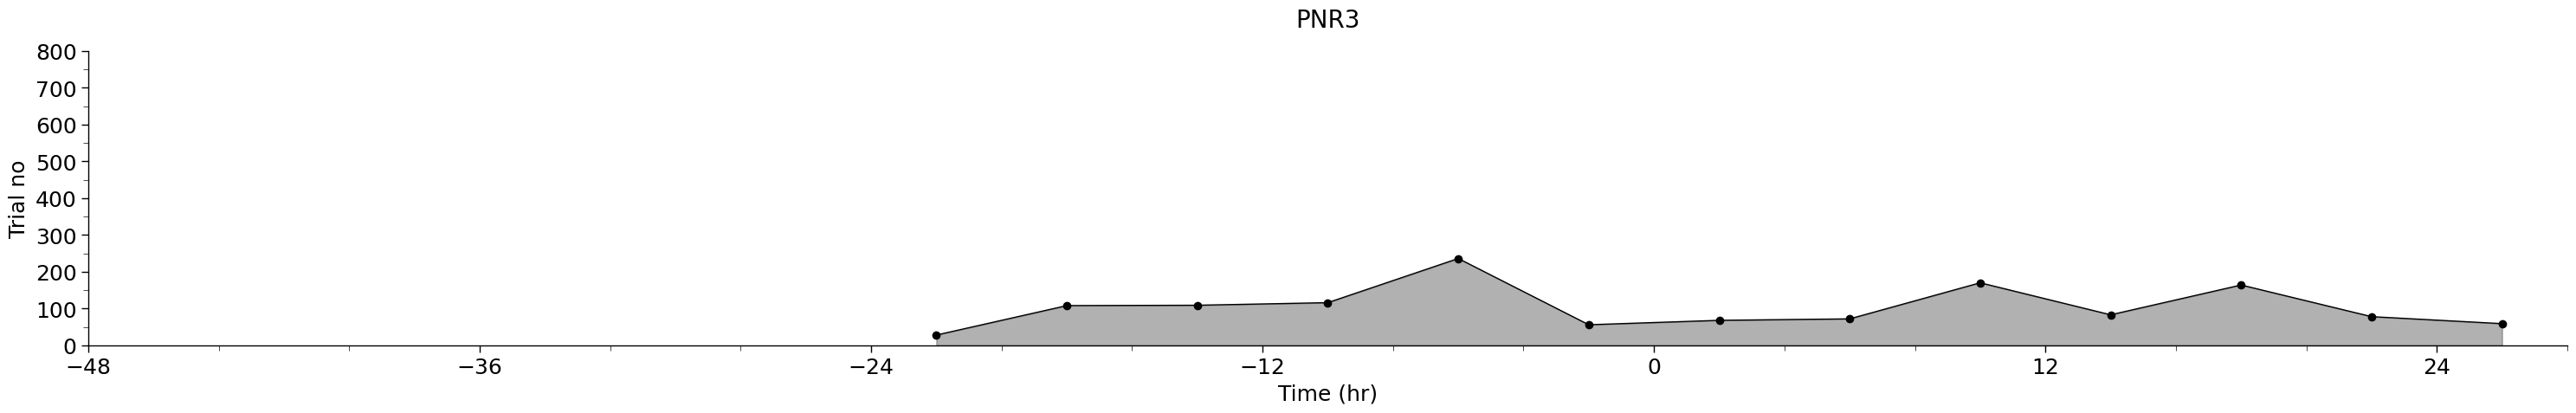

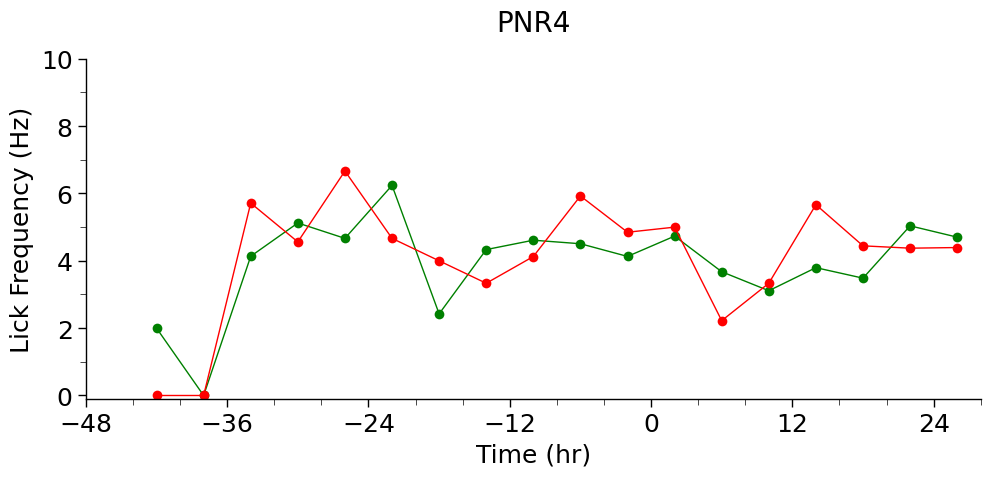

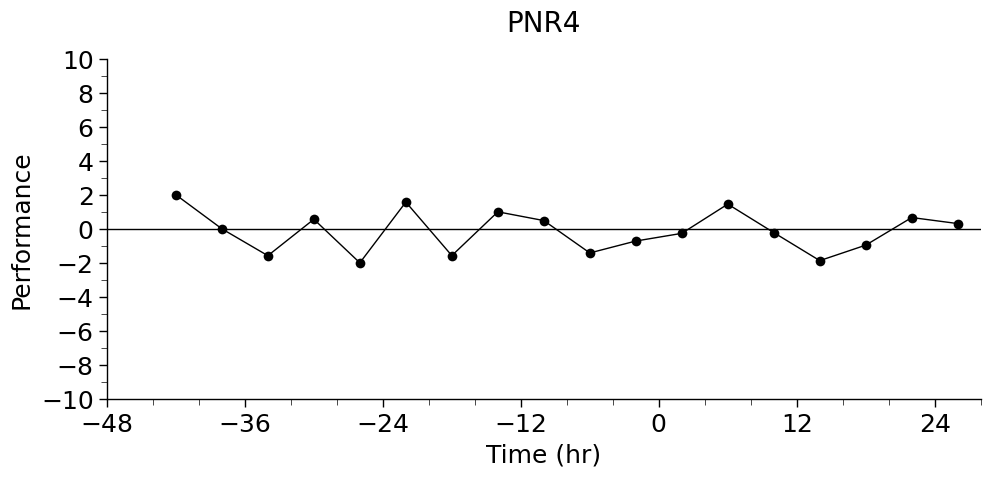

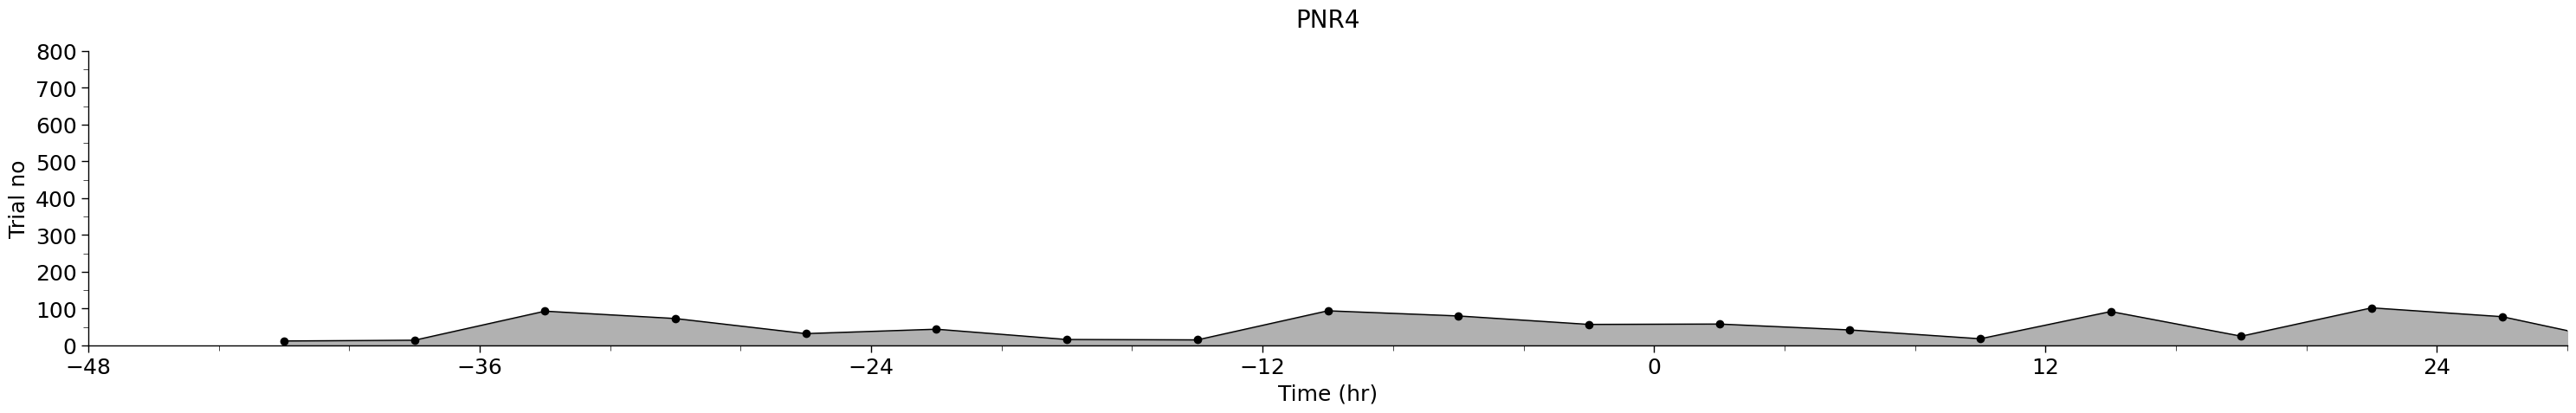

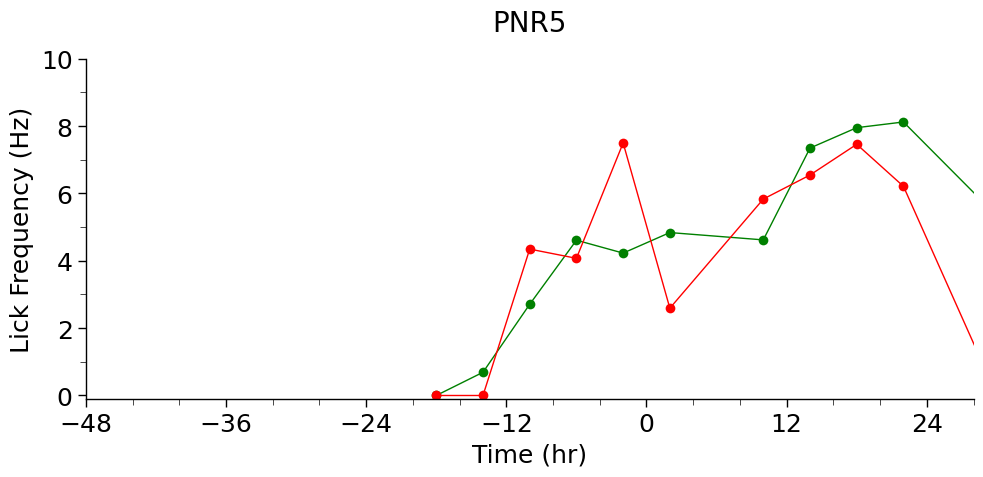

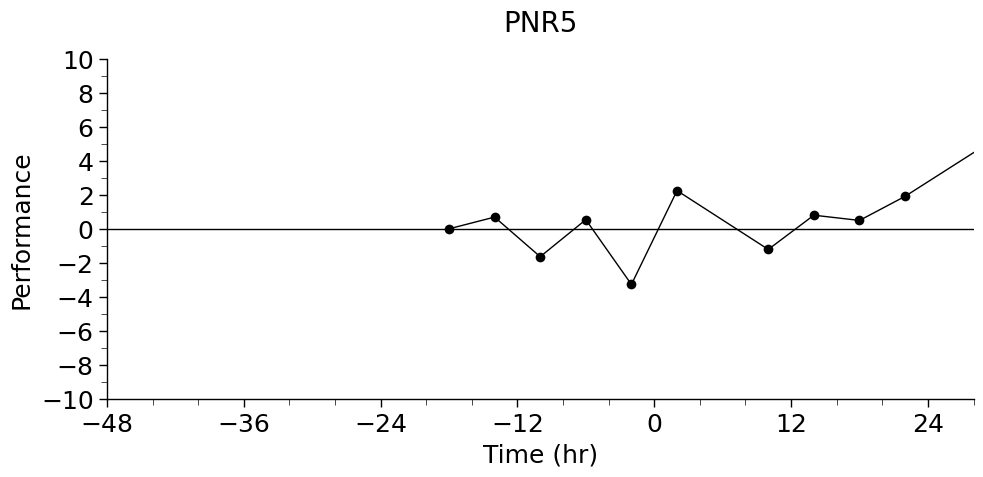

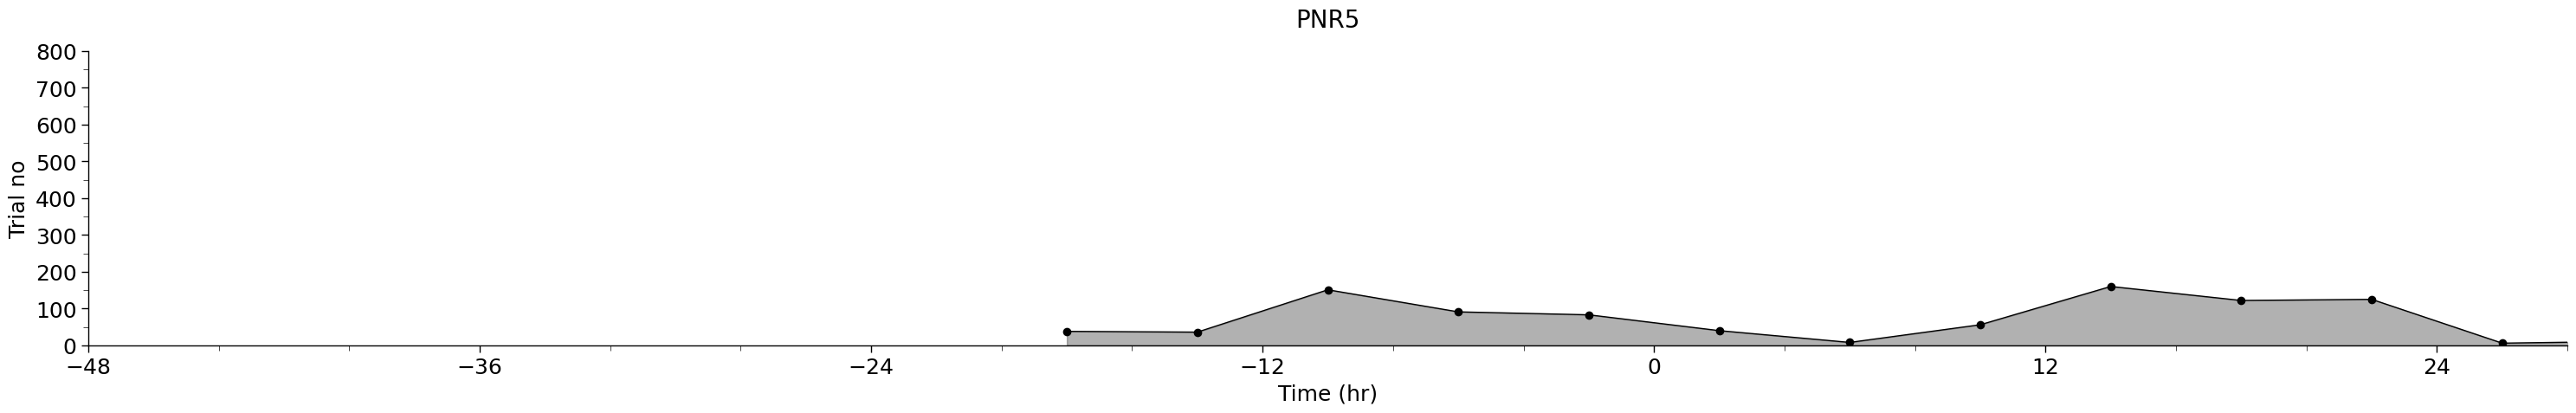

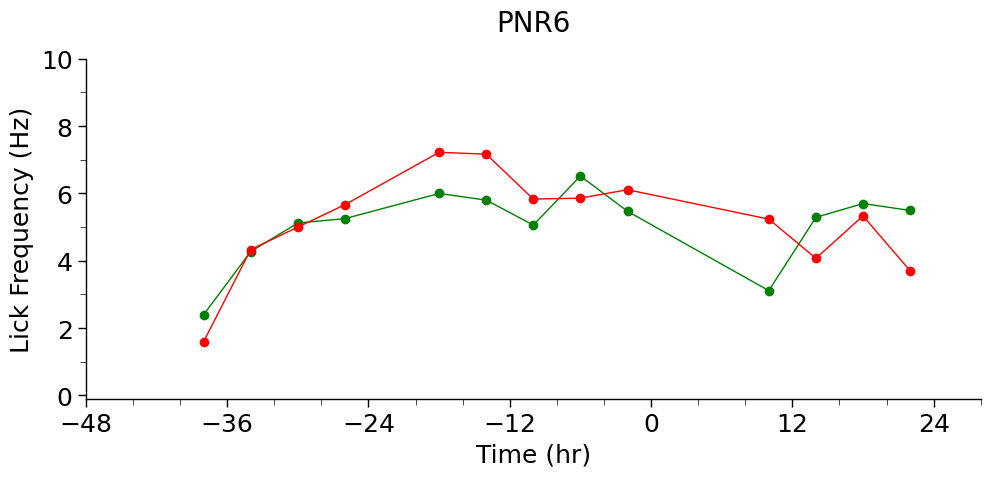

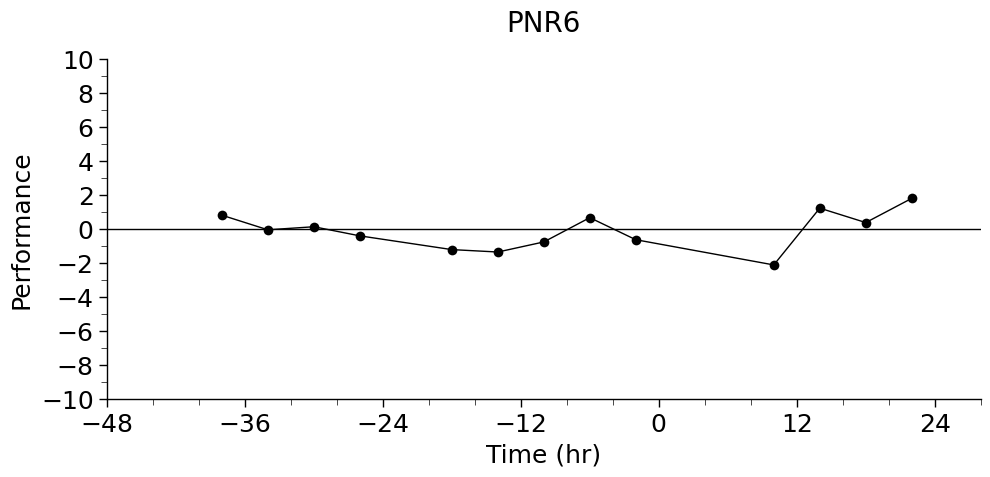

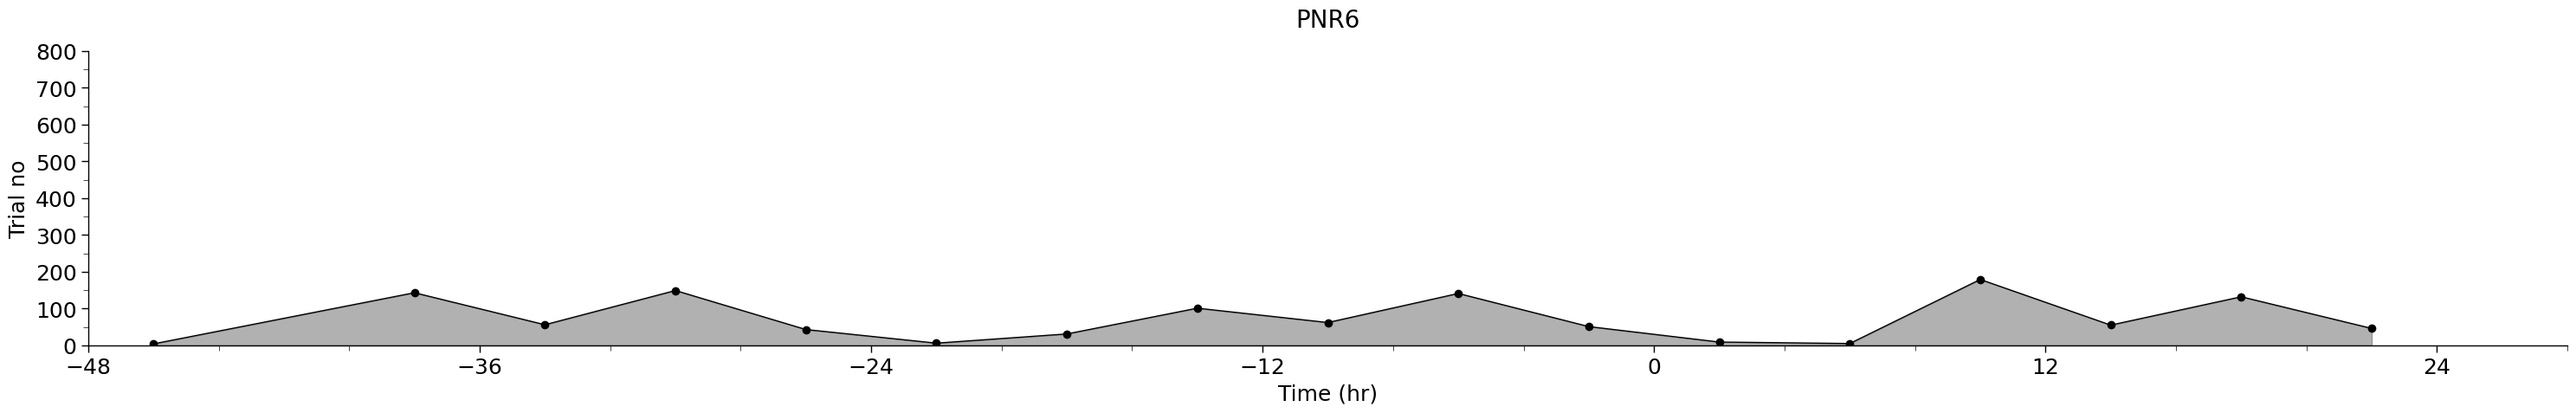

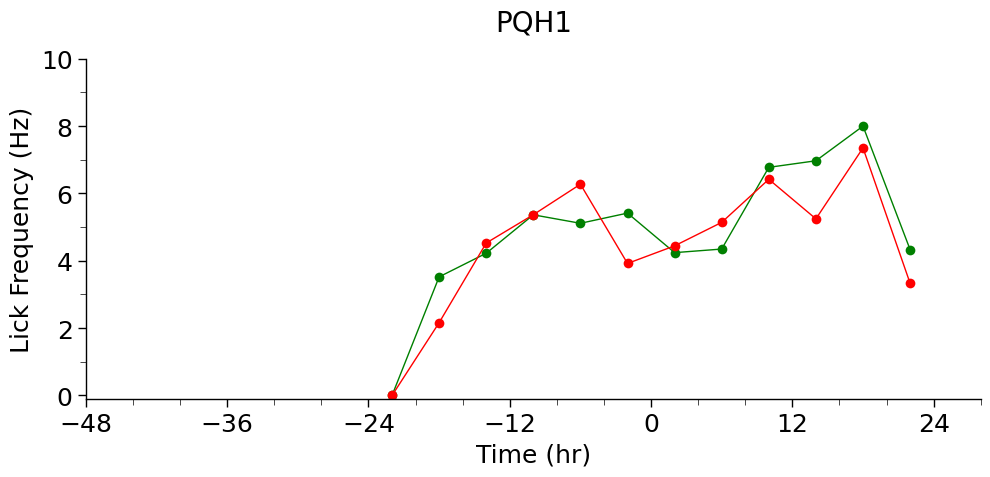

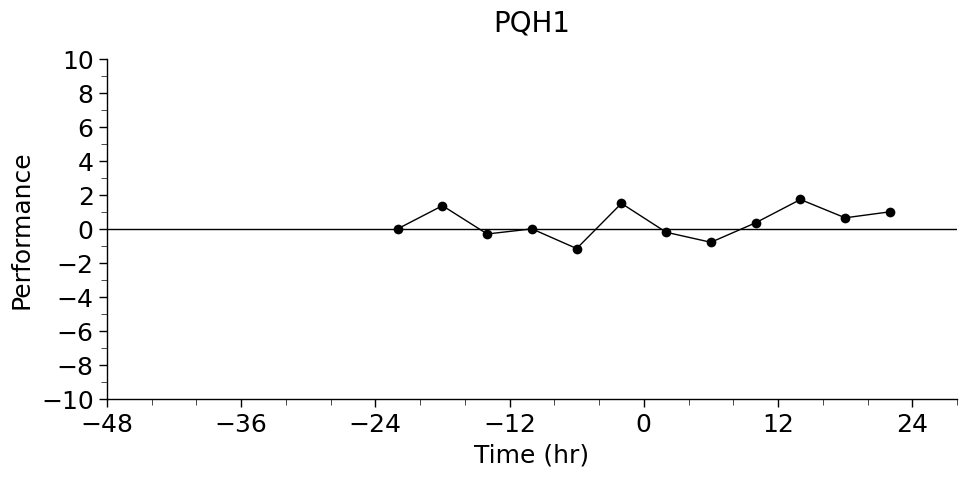

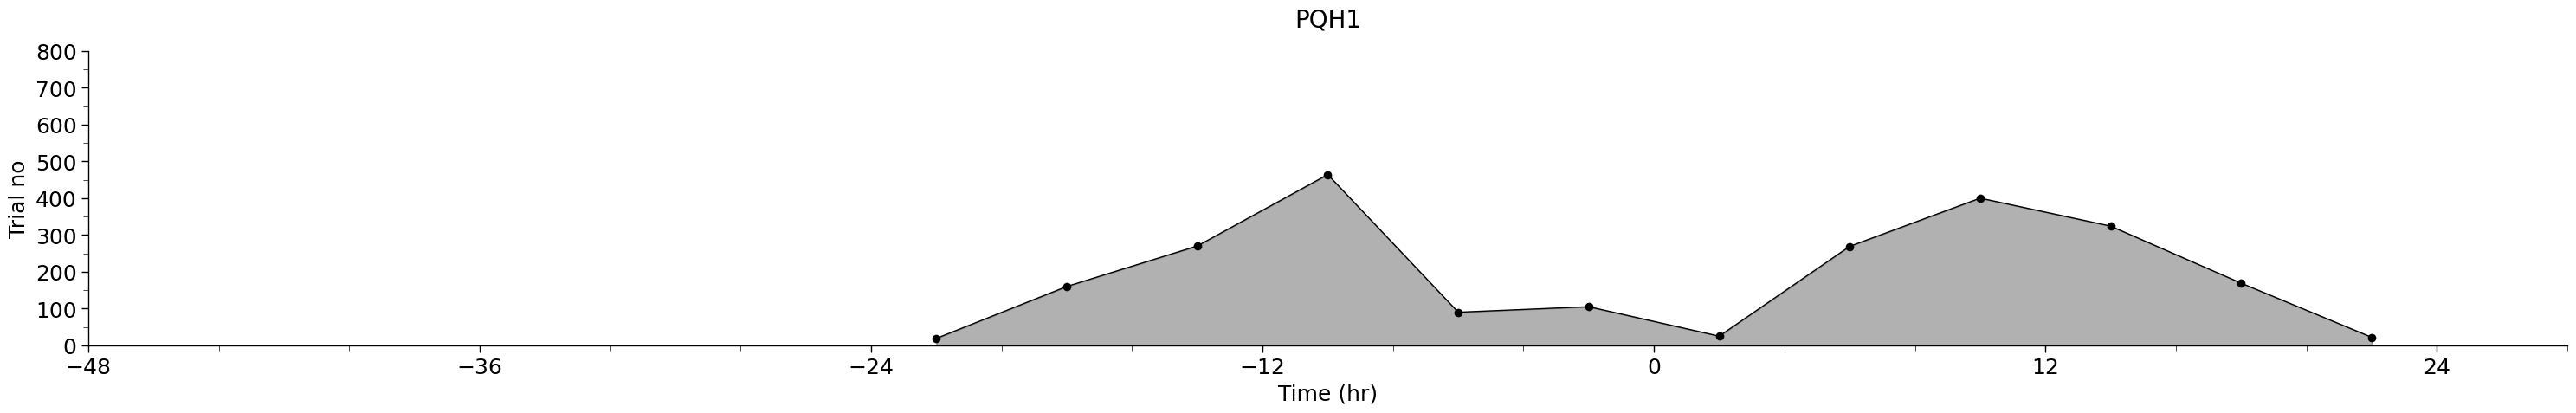

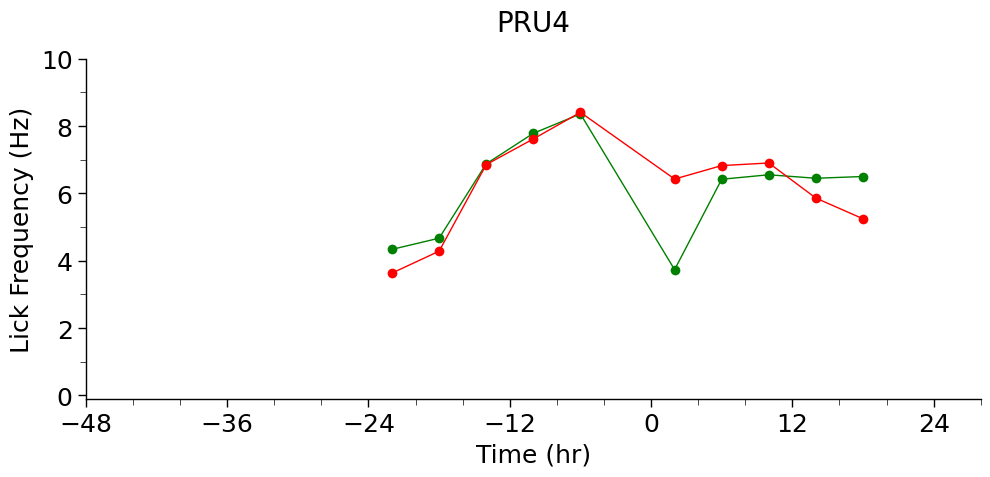

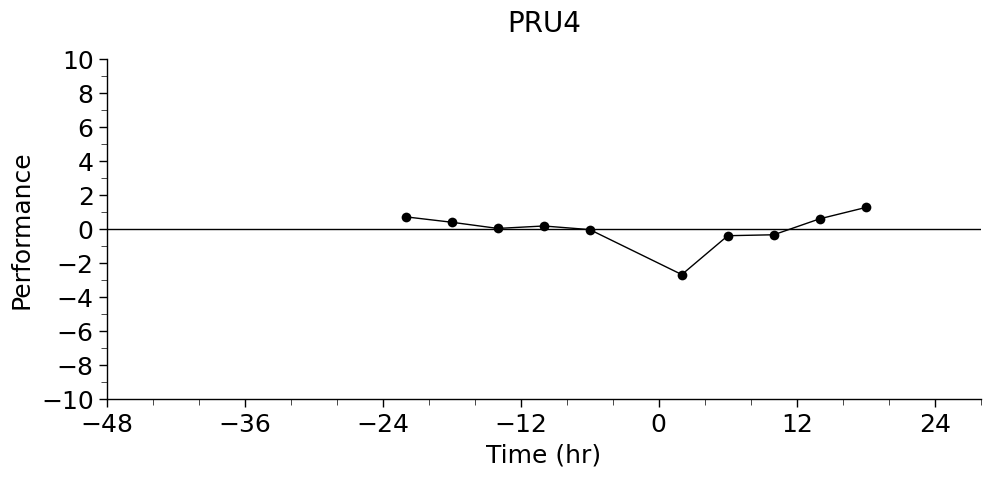

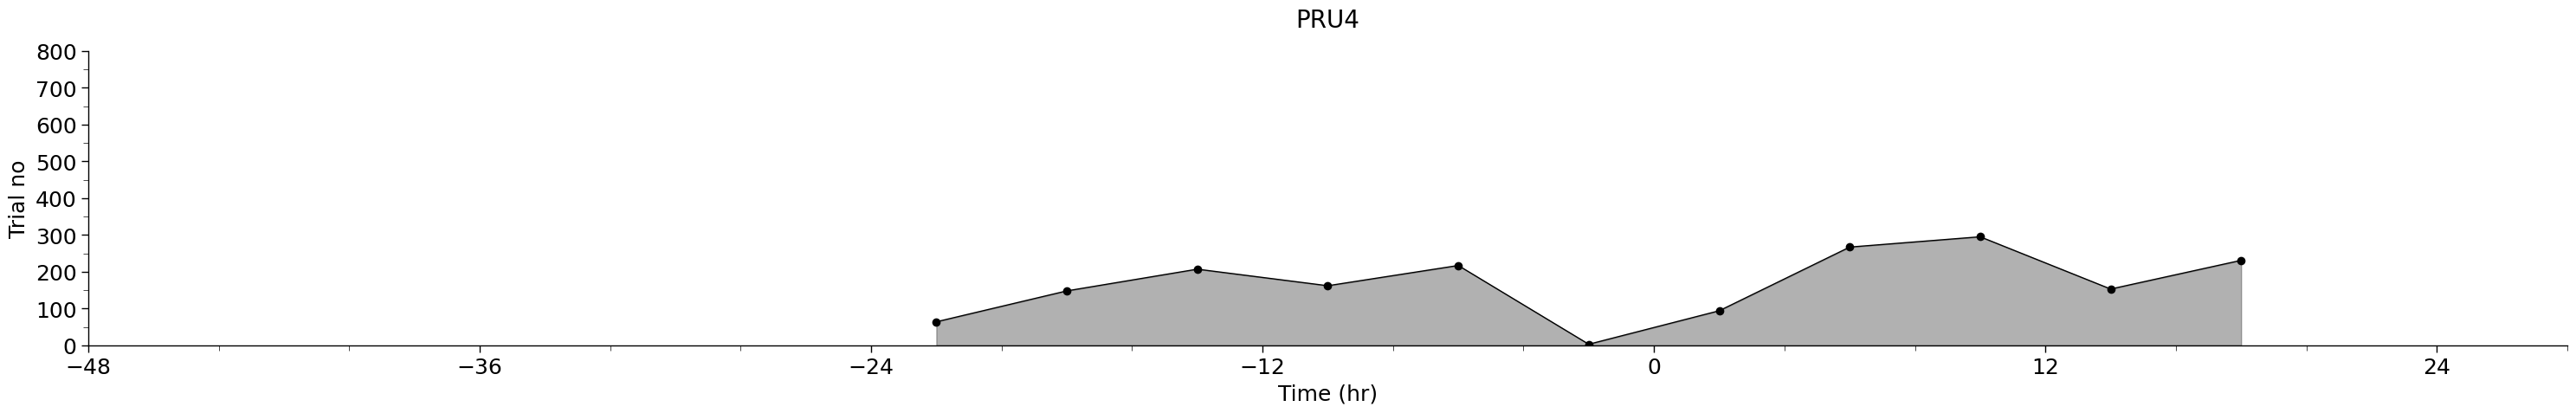

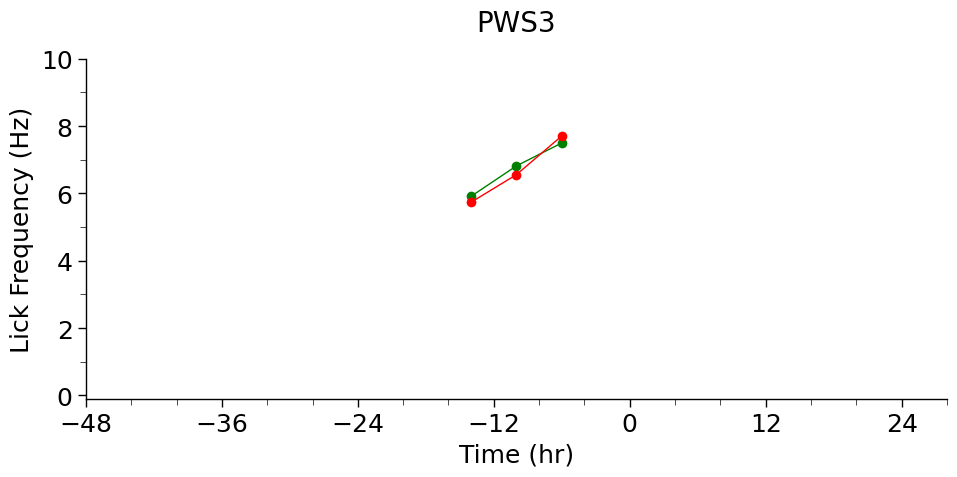

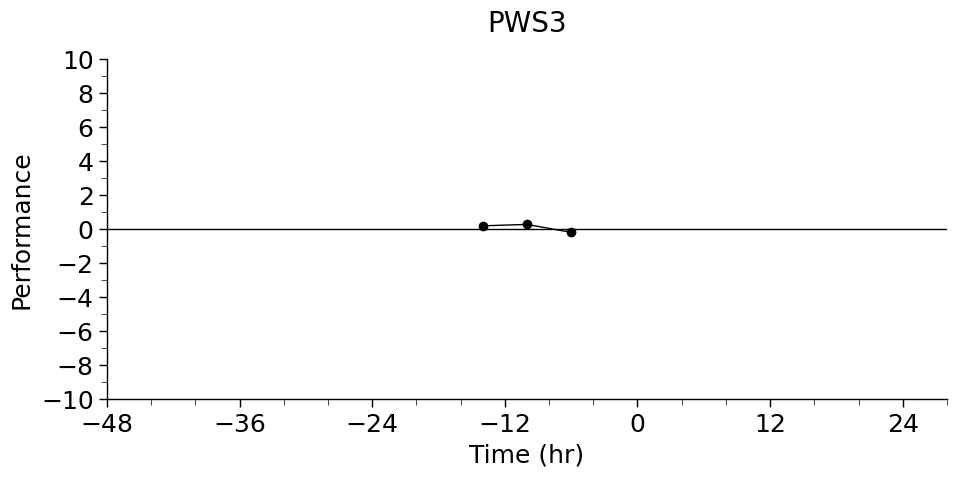

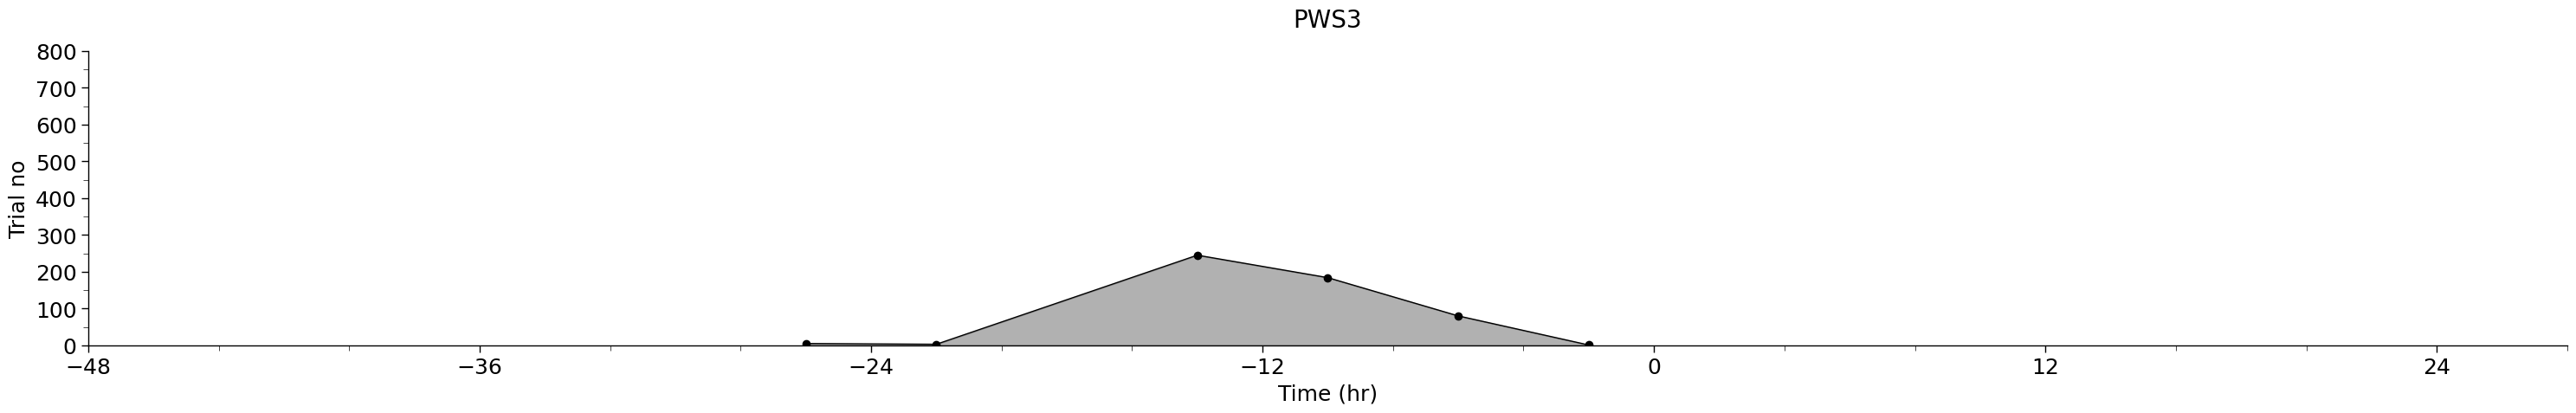

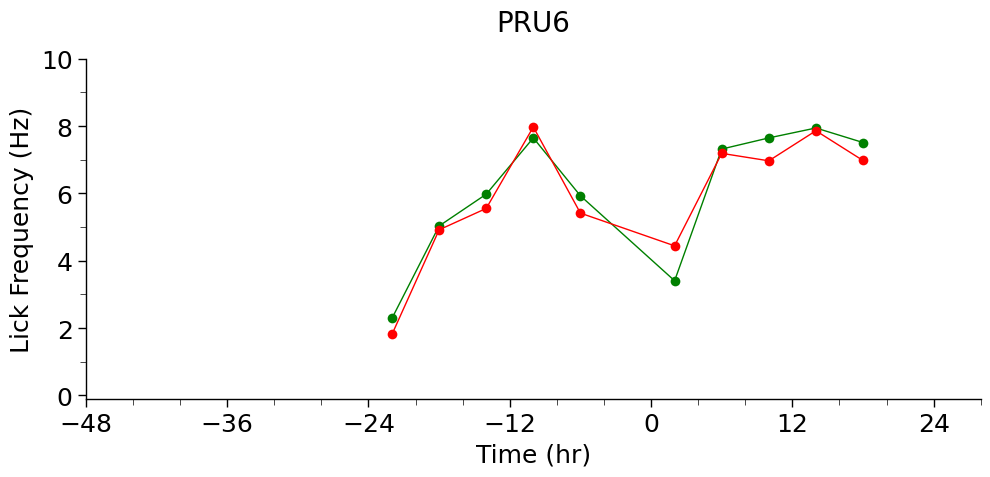

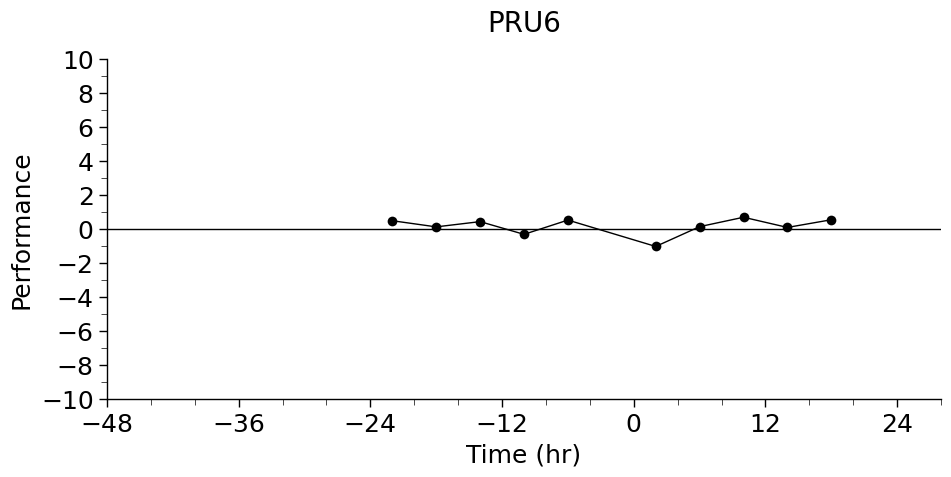

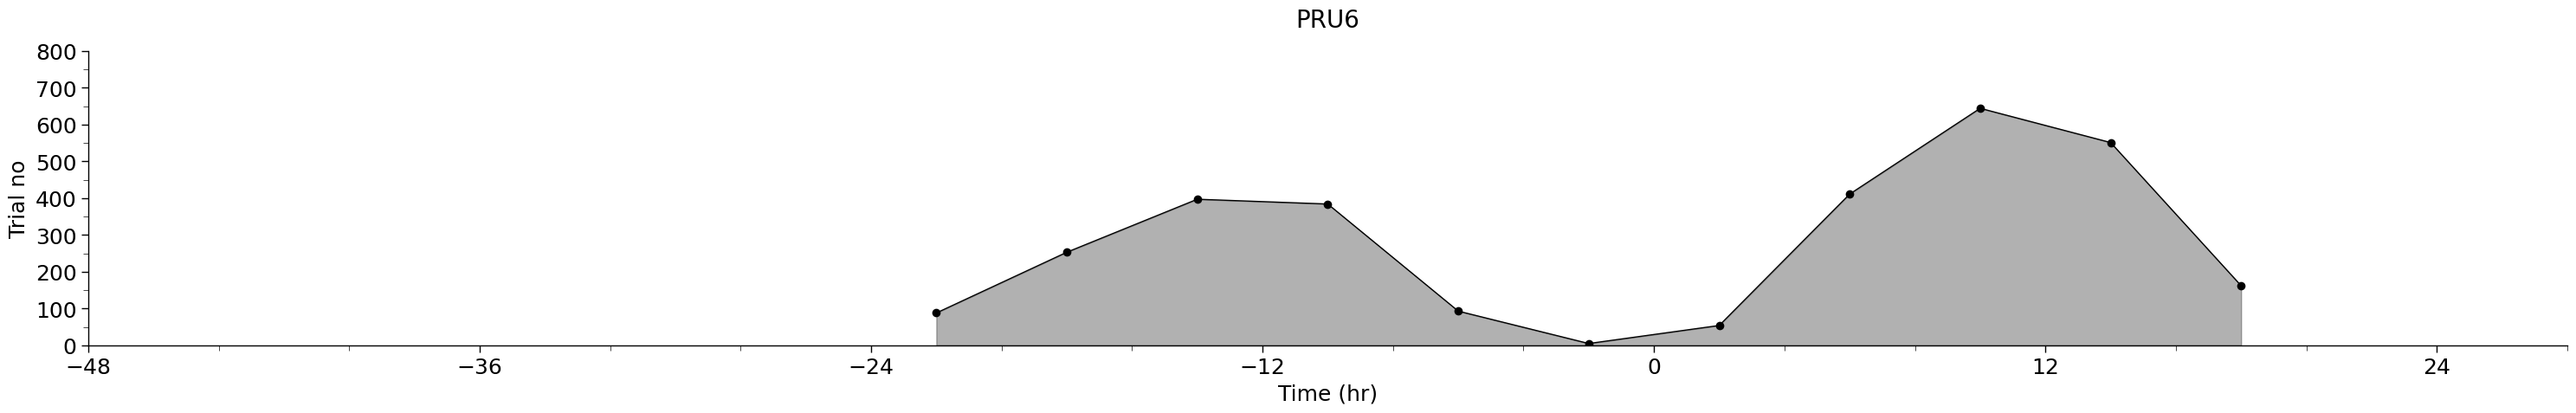

In [16]:
xlim=[-48,28]
conds = ['6ohda', '6ohda partial']
for c in conds:
    tmp = ant_means[ant_means['condition'] == c]
    for a in tmp["animal"].unique():          
        g = plot_ant_lickfreq(ant_means[(ant_means["animal"] == a)],y='lick',
                              aspect=2,lw=1, ms=7, title=a, legend=False, 
                              xlim=xlim, ylim=[-0.1, 10], errorbar='se', 
                              err_style='bars', err_kws={"lw":0.5})
        g = plot_ant_perf(ant_perf[(ant_perf["animal"] == a)], ylabel="Performance", 
                          aspect=2,lw=1, ms=7,xlim=xlim, legend=False, 
                          ylim=[-10, 10], title=a,errorbar='se', 
                          err_style='bars', err_kws={"lw":0.5})
        g = plot_trial_hr(trials[(trials["animal"] == a)], xlim=xlim, 
                          ylim=[0, 800], aspect=6, title=a, ms=7, lw=1,
                          err_kws={"lw":0.5}, ylabel='Trial no')